In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir = '/mnt/share/costeffectiveness/results/vivarium_ciff_sam/v7.0.0_full_model_no_x_factor/ciff_sam/2022_03_04_17_34_48/count_data/'

In [3]:
pd.read_csv(output_dir + 'wasting_transition_count.csv').age.unique()

array(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months',
       '12_to_23_months', '2_to_4'], dtype=object)

In [4]:
def calculate_wasting_values(output_dir, ages, strata_cols, measure, metric, 
                             relative_scenario):
    if measure=='prevalence':
        data = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        wasted = data.loc[data.cause.str.contains('acute_malnutrition')]
        wasted['cause'] = 'wasted'
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
    elif measure=='incidence':
        data = (pd.read_csv(output_dir + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        wasted = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'])]
        wasted['cause'] = 'wasted'
        total_mam = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                             'severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count'])]
        total_mam['cause'] = 'total_mam'
        wasted = pd.concat([wasted,total_mam])
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
        pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        groupby_cols = ['input_draw','scenario','cause']
    data = data.loc[data.age.isin(ages)]    
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    if measure=='prevalence':
        data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    else:
        pt = pt.loc[pt.age.isin(ages)].groupby(['input_draw','scenario'] + strata_cols).sum()
        data = data / pt * 100_000     
    if metric=='value':
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
    return data[['value']].reset_index()

In [5]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']
ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [6]:
pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
pt = pt.loc[pt.age.isin(ages)]

trans = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns=['Unnamed: 0'])
trans = trans.loc[trans.age.isin(ages)]
trans['cause'] = (trans.measure
                  .str.replace('susceptible_to_child_wasting','tmrel')
                  .str.split('_to_',expand=True)[1]
                  .str.split('_event_count',expand=True)[0]
                  .str.replace('tmrel','susceptible_to_child_wasting'))
cols = ['input_draw','scenario','cause','year']
data = (pt.groupby(cols).sum() / trans.groupby(cols).sum() * 365).reset_index()
data = data.loc[data.year==2026].groupby(['cause','scenario']).describe(percentiles=[0.025,0.975])['value']
data

count        mean  \
cause                        scenario                                  
mild_child_wasting           baseline               11.0  148.981364   
                             lbwsg_interventions    11.0  160.999469   
                             mam_treatment          11.0  148.703983   
                             sam_treatment          11.0  148.934252   
                             sqlns                  11.0  160.650783   
                             zinc_supplementation   11.0  166.466962   
moderate_acute_malnutrition  baseline               11.0  101.764989   
                             lbwsg_interventions    11.0   89.123210   
                             mam_treatment          11.0   88.007611   
                             sam_treatment          11.0  101.994340   
                             sqlns                  11.0   89.374850   
                             zinc_supplementation   11.0   90.207733   
severe_acute_malnutrition    baseline               11.0  113.403748   
                             lbwsg_interventions    11.0   99.479534   
                             mam_treatment          11.0   97.604778   
                             sam_treatment          11.0   95.569366   
                             sqlns                  11.0   99.819393   
                             zinc_supplementation   11.0  101.302376   
susceptible_to_child_wasting baseline               11.0  969.598461   
                             lbwsg_interventions    11.0  949.218763   
                             mam_treatment          11.0  953.492180   
                             sam_treatment          11.0  964.581470   
                             sqlns                  11.0  949.558881   
                             zinc_supplementation   11.0  982.724050   

                                                          std         min  \
cause                        scenario                                       
mild_child_wasting           baseline               33.447810  105.373580   
                             lbwsg_interventions    38.386862  110.466827   
                             mam_treatment          33.295715  105.282270   
                             sam_treatment          33.403717  105.408133   
                             sqlns                  38.256634  110.328972   
                             zinc_supplementation   39.839521  113.599739   
moderate_acute_malnutrition  baseline                3.191676   96.328625   
                             lbwsg_interventions     2.358496   84.498725   
                             mam_treatment           2.297871   83.575006   
                             sam_treatment           3.259893   96.500843   
                             sqlns                   2.375887   84.722792   
                             zinc_supplementation    2.351222   85.500585   
severe_acute_malnutrition    baseline                8.892973   99.552577   
                             lbwsg_interventions     5.900461   91.506085   
                             mam_treatment           5.555935   90.013677   
                             sam_treatment           5.337653   88.245943   
                             sqlns                   5.897650   91.805560   
                             zinc_supplementation    6.375448   93.410142   
susceptible_to_child_wasting baseline              353.864792  550.269586   
                             lbwsg_interventions   339.173080  543.052087   
                             mam_treatment         343.317495  545.838941   
                             sam_treatment         350.566231  548.957731   
                             sqlns                 339.543821  543.288203   
                             zinc_supplementation  344.097992  566.419787   

                                                         2.5%         50%  \
cause                        scenario                                       
mild_child_wasting   

## Finding 1: cross sectional prevalence

In [7]:
t = calculate_wasting_values(output_dir, ages, ['year'], 'prevalence', 'value', 
                             'baseline')

t = t.loc[t.year==2026]
t['result'] = (t['value','mean'].round(1).astype(str)
              + ' ('
              + t['value','2.5%'].round(1).astype(str)
              + ', '
              + t['value','97.5%'].round(1).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,
                                      np.where(t.scenario=='sqlns',2,
                                              np.where(t.scenario=='zinc_supplementation',3,4))))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


scenario             result                              \
                                                                             
cause                       mild_child_wasting moderate_acute_malnutrition   
0                  baseline  19.1 (18.7, 20.0)              6.7 (6.3, 6.9)   
4                     sqlns  20.4 (19.8, 21.5)              5.1 (4.7, 5.2)   
5      zinc_supplementation  20.0 (19.3, 21.5)              4.7 (4.4, 4.8)   
1       lbwsg_interventions  20.4 (19.8, 21.5)              5.0 (4.7, 5.2)   
2             mam_treatment  20.0 (19.5, 21.0)              5.8 (5.3, 6.1)   
3             sam_treatment  19.4 (19.0, 20.4)              6.5 (6.1, 6.8)   

                                                                              
                                                                              
cause severe_acute_malnutrition susceptible_to_child_wasting          wasted  
0                1.6 (1.5, 1.7)            64.3 (63.9, 64.7)  8.3 (7.8, 8.6)  
4                1.1 (1.0, 1.2)            67.4 (66.9, 67.8)  6.1 (5.7, 6.4)  
5                1.0 (0.9, 1.1)            68.7 (67.5, 69.5)  5.7 (5.4, 5.8)  
1                1.1 (1.0, 1.2)            67.4 (67.0, 67.8)  6.1 (5.7, 6.4)  
2                1.2 (1.1, 1.3)            66.1 (65.5, 66.7)  7.0 (6.4, 7.4)  
3                1.3 (1.2, 1.4)            64.9 (64.4, 65.3)  7.8 (7.3, 8.2)

In [8]:
t = calculate_wasting_values(output_dir, ages, ['year'], 'prevalence', 'absolute_reduction', 
                             'baseline')

t = t.loc[t.year==2026]
t['result'] = (t['value','mean'].round(1).astype(str)
              + ' ('
              + t['value','2.5%'].round(1).astype(str)
              + ', '
              + t['value','97.5%'].round(1).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,
                                      np.where(t.scenario=='sqlns',2,
                                              np.where(t.scenario=='zinc_supplementation',3,4))))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


scenario             result                              \
                                                                             
cause                       mild_child_wasting moderate_acute_malnutrition   
0                  baseline     0.0 (0.0, 0.0)              0.0 (0.0, 0.0)   
4                     sqlns  -1.2 (-1.4, -1.0)              1.7 (1.4, 1.9)   
5      zinc_supplementation  -0.9 (-1.5, -0.4)              2.1 (1.7, 2.3)   
1       lbwsg_interventions  -1.2 (-1.5, -1.0)              1.7 (1.5, 1.9)   
2             mam_treatment  -0.8 (-1.0, -0.7)              0.9 (0.8, 1.2)   
3             sam_treatment  -0.3 (-0.4, -0.2)              0.2 (0.1, 0.3)   

                                                                              
                                                                              
cause severe_acute_malnutrition susceptible_to_child_wasting          wasted  
0                0.0 (0.0, 0.0)               0.0 (0.0, 0.0)  0.0 (0.0, 0.0)  
4                0.5 (0.4, 0.6)            -3.1 (-3.6, -2.6)  2.2 (1.9, 2.4)  
5                0.6 (0.5, 0.6)            -4.4 (-4.9, -3.1)  2.6 (2.3, 2.9)  
1                0.5 (0.4, 0.6)            -3.1 (-3.6, -2.6)  2.2 (1.9, 2.5)  
2                0.4 (0.3, 0.5)            -1.8 (-2.3, -1.6)  1.3 (1.2, 1.6)  
3                0.3 (0.2, 0.3)            -0.6 (-0.9, -0.5)  0.5 (0.4, 0.6)

<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


Text(1.5, 2.7, 'Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 59 months\n(with 95% uncertainty intervals)')

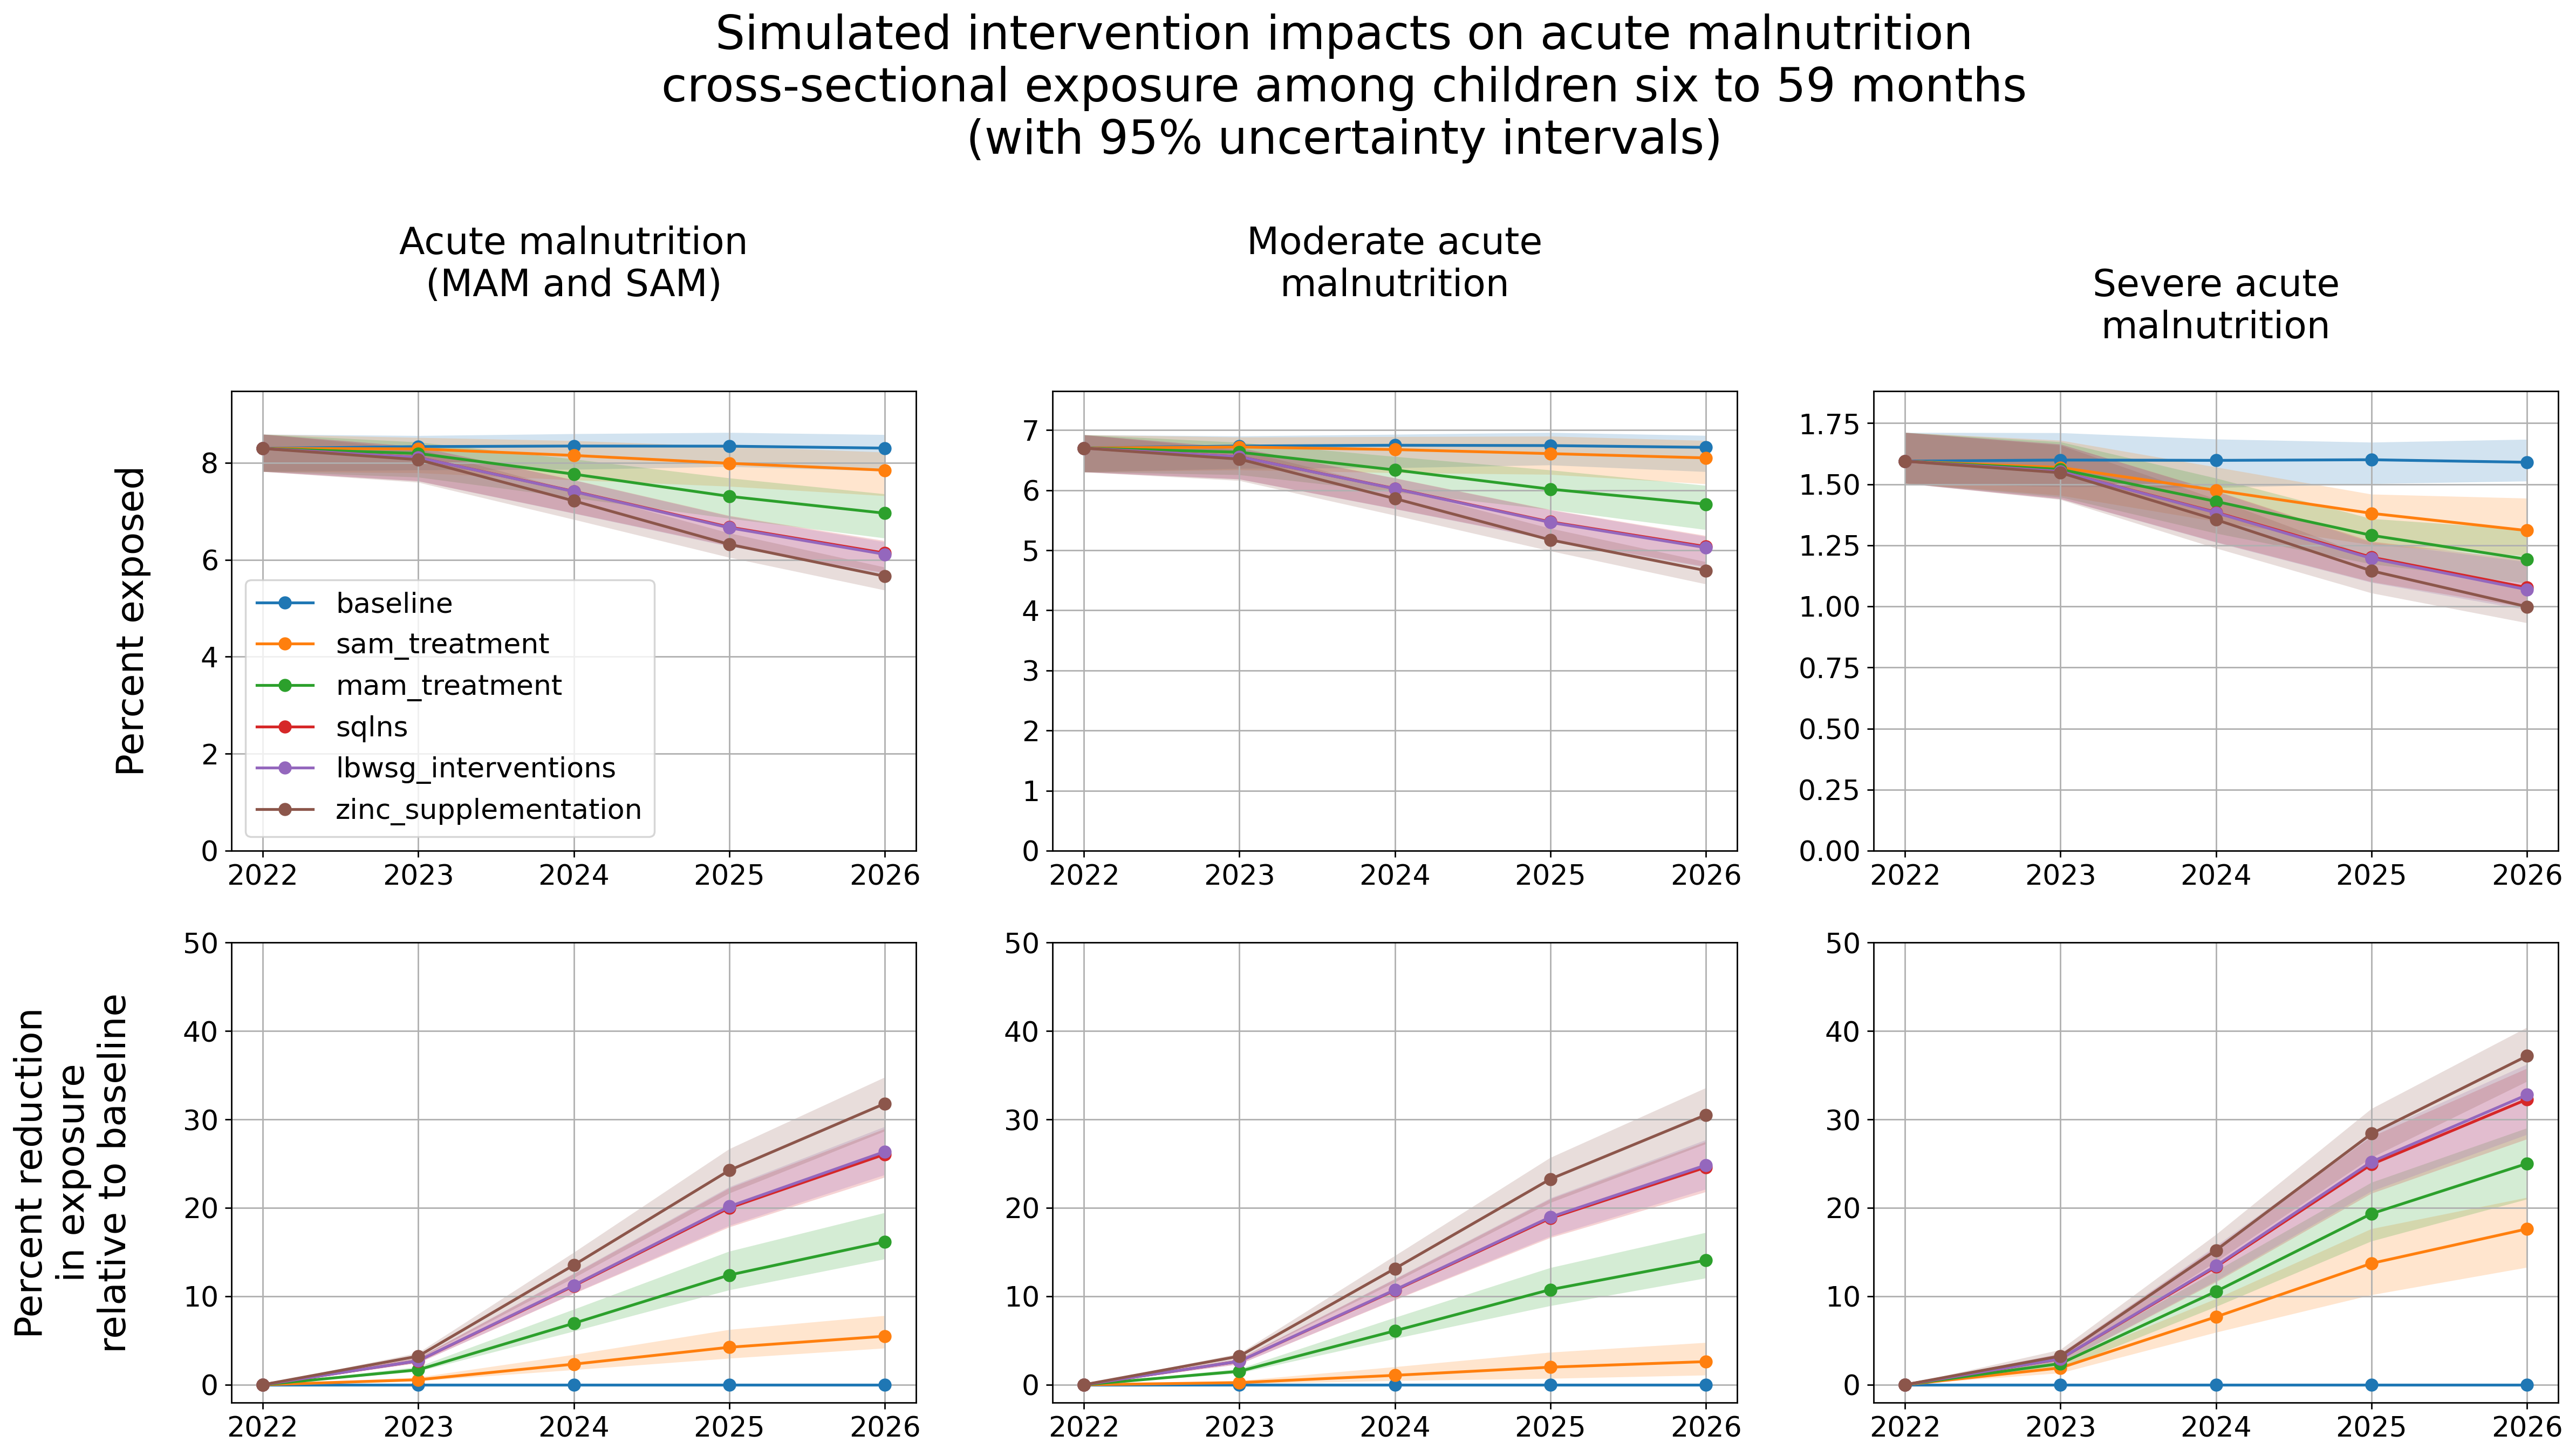

In [9]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'prevalence', 
                                        metric, 
                                        'baseline')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        for i in ['baseline','sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']:
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if metrics.index(metric)==0:
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent exposed\n',size=20)
                pos.legend(#['Baseline','+Wasting Treatment','+SQ-LNS','+Zinc supplementation'], 
                       fontsize=15)
        if metric=='percent_reduction':
            pos.set_ylim(-2,50)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent reduction\nin exposure\nrelative to baseline\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 59 months\n(with 95% uncertainty intervals)',
             y=2.7,x=1.5,size=25)

<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


Text(1.5, 2.7, 'Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 11 months\n(with 95% uncertainty intervals)')

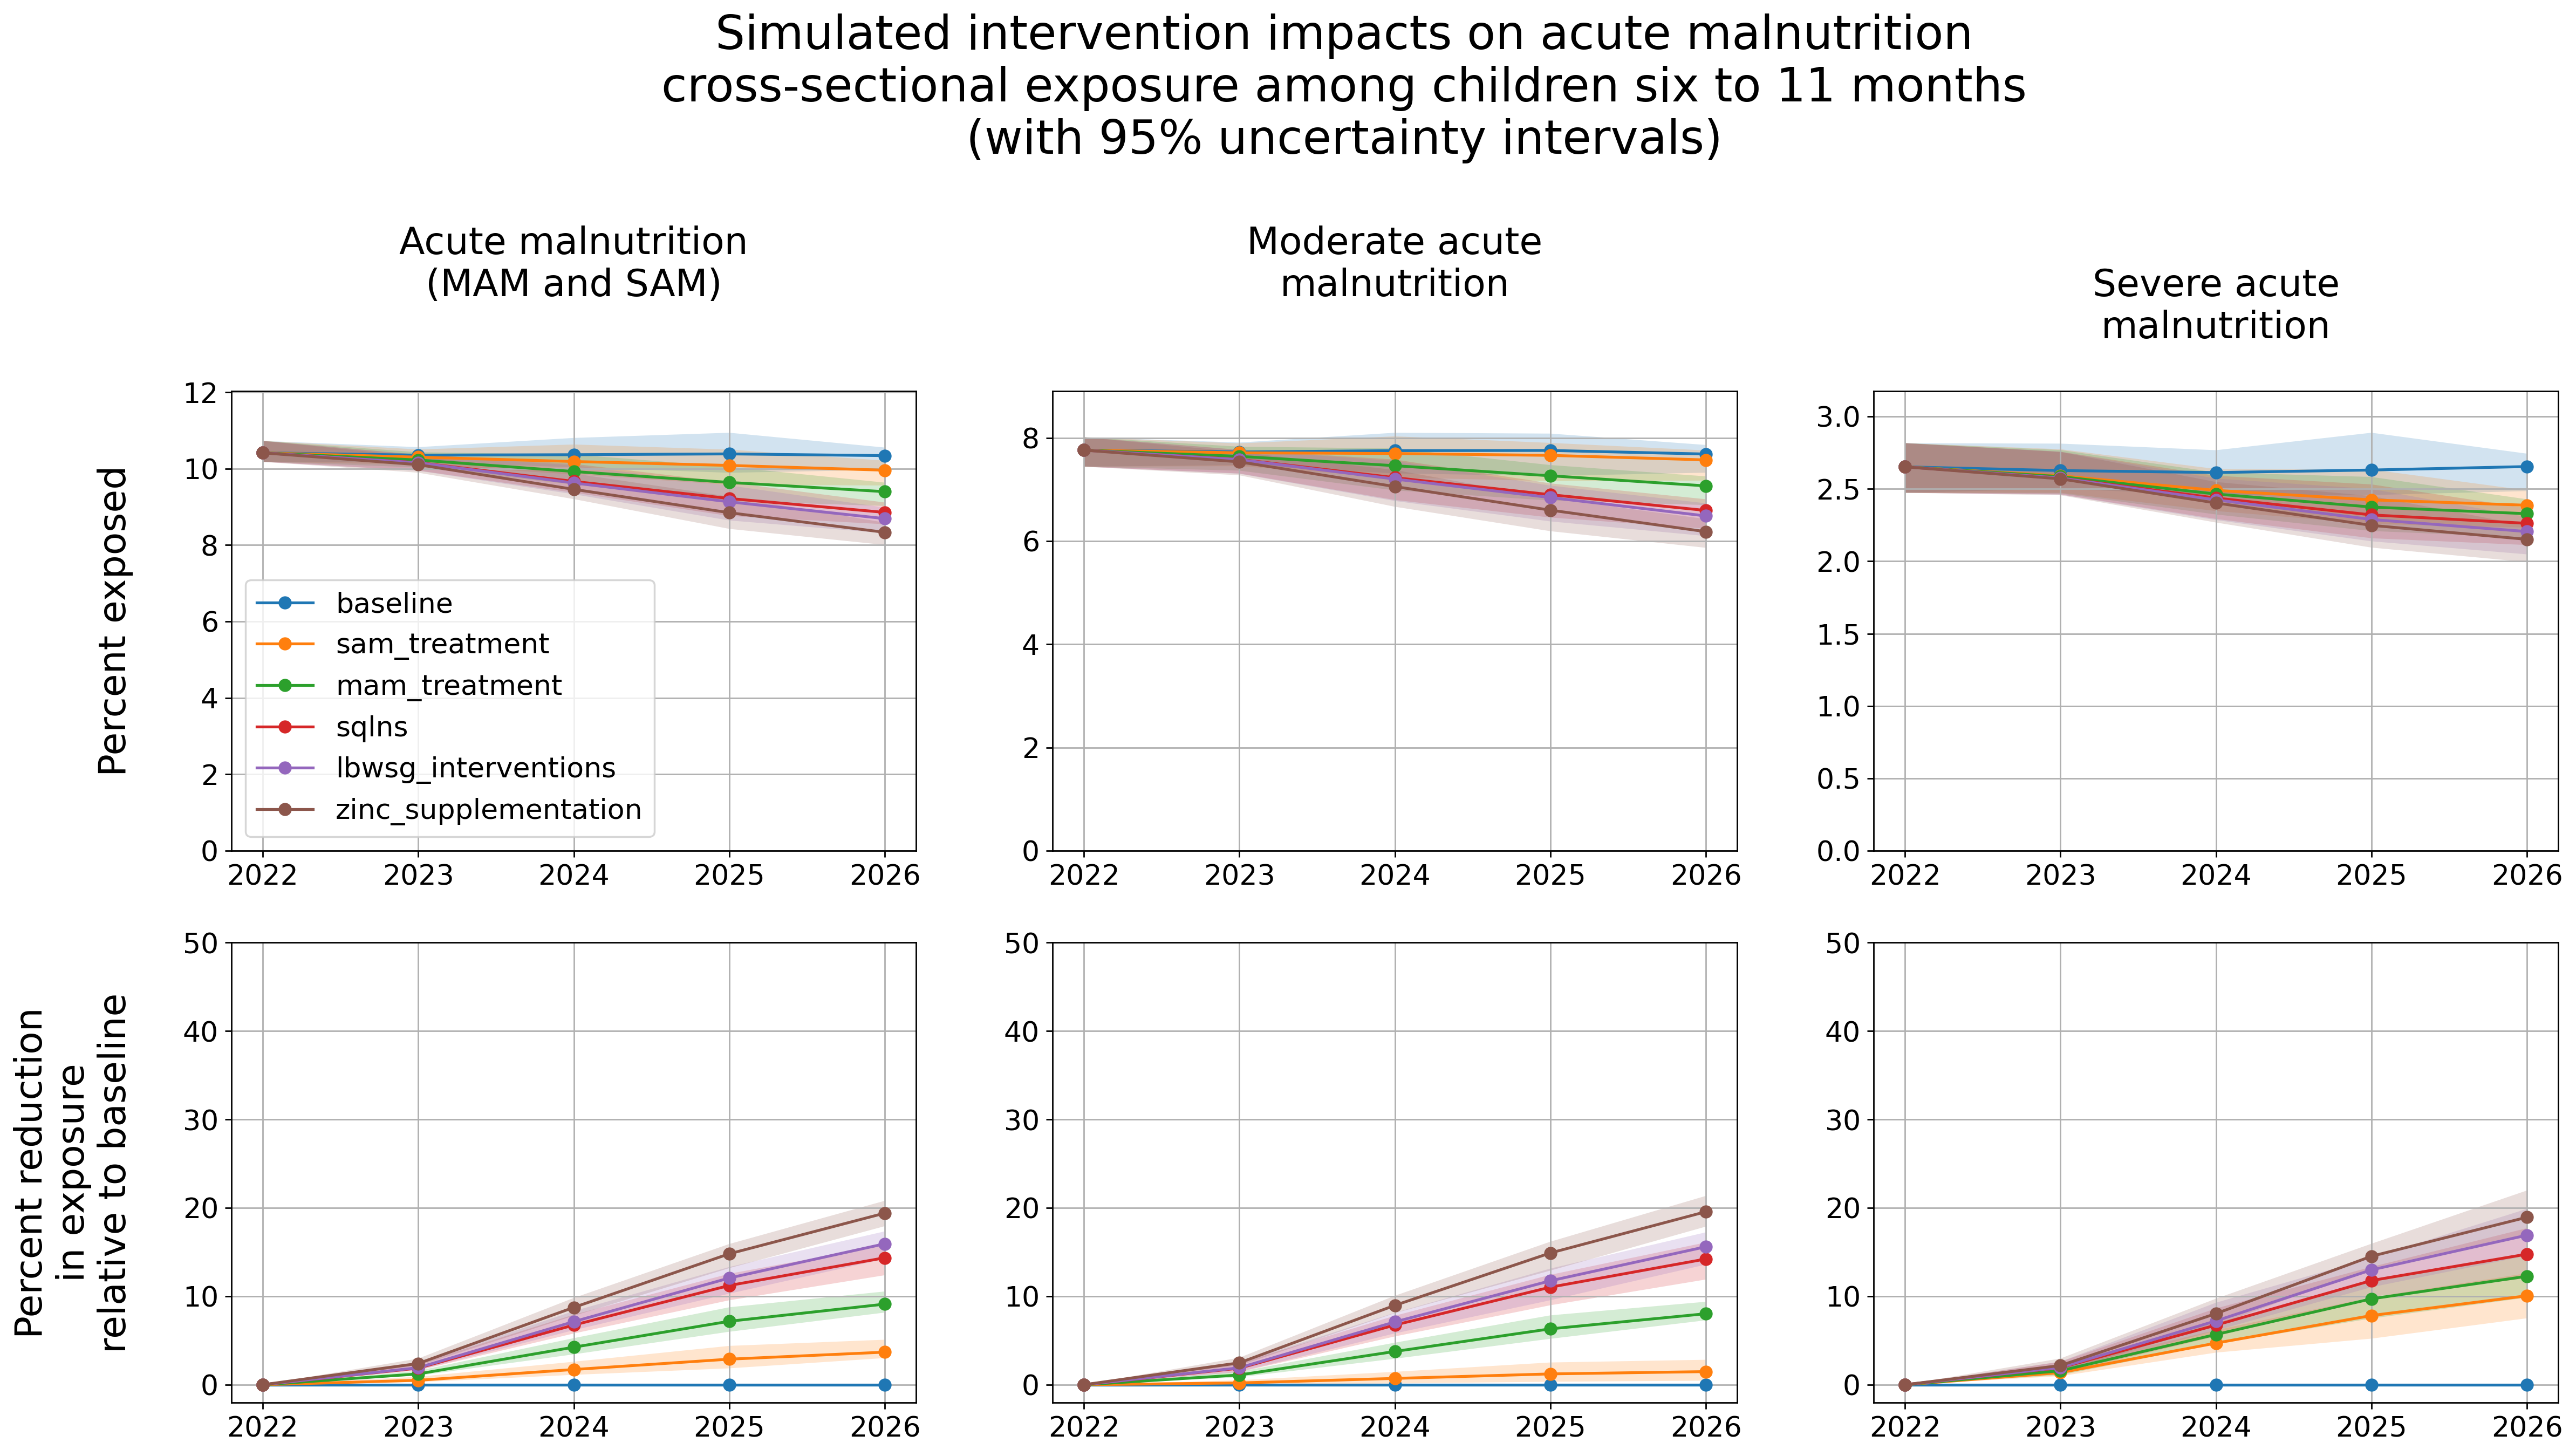

In [10]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, ['6-11_months'], ['year'], 
                                        'prevalence', 
                                        metric, 
                                        'baseline')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        for i in ['baseline','sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']:
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if metrics.index(metric)==0:
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent exposed\n',size=20)
                pos.legend(#['Baseline','+Wasting Treatment','+SQ-LNS','+Zinc supplementation'], 
                       fontsize=15)
        if metric=='percent_reduction':
            pos.set_ylim(-2,50)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent reduction\nin exposure\nrelative to baseline\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children six to 11 months\n(with 95% uncertainty intervals)',
             y=2.7,x=1.5,size=25)

# Finding 2: incidence

In [11]:
t = calculate_wasting_values(output_dir, ages, ['year'], 'incidence', 'value', 
                             'baseline')
t = t.loc[(t.year==2026)
         &(t.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                        'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count']))]
t['result'] = (t['value','mean'].round(0).astype(int).astype(str)
              + ' ('
              + t['value','2.5%'].round(0).astype(int).astype(str)
              + ', '
              + t['value','97.5%'].round(0).astype(int).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,
                                      np.where(t.scenario=='sqlns',2,
                                              np.where(t.scenario=='zinc_supplementation',3,4))))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-4-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'


scenario  \
                              
cause                         
0                  baseline   
4                     sqlns   
5      zinc_supplementation   
1       lbwsg_interventions   
2             mam_treatment   
3             sam_treatment   

                                                             result  \
                                                                      
cause mild_child_wasting_to_moderate_acute_malnutrition_event_count   
0                                   23636 (20877, 25599)              
4                                   20805 (18581, 22243)              
5                                   18870 (17186, 20340)              
1                                   20797 (18569, 22217)              
2                                   24358 (21590, 26468)              
3                                   23883 (21121, 25871)              

                                                                            
                                                                            
cause moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count  
0                                      5615 (4948, 6546)                    
4                                      4211 (3702, 4929)                    
5                                      3829 (3435, 4425)                    
1                                      4192 (3676, 4906)                    
2                                      4809 (4231, 5581)                    
3                                      5450 (4797, 6346)

In [12]:
t = calculate_wasting_values(output_dir, ages, ['year'], 'incidence', 'absolute_reduction', 
                             'baseline')
t = t.loc[(t.year==2026)
         &(t.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                        'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count']))]
t['result'] = (t['value','mean'].round(0).astype(int).astype(str)
              + ' ('
              + t['value','2.5%'].round(0).astype(int).astype(str)
              + ', '
              + t['value','97.5%'].round(0).astype(int).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,
                                      np.where(t.scenario=='sqlns',2,
                                              np.where(t.scenario=='zinc_supplementation',3,4))))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-4-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'


scenario  \
                              
cause                         
0                  baseline   
4                     sqlns   
5      zinc_supplementation   
1       lbwsg_interventions   
2             mam_treatment   
3             sam_treatment   

                                                             result  \
                                                                      
cause mild_child_wasting_to_moderate_acute_malnutrition_event_count   
0                                               0 (0, 0)              
4                                      2831 (1901, 3758)              
5                                      4766 (3391, 5850)              
1                                      2839 (1908, 3781)              
2                                      -722 (-869, -585)              
3                                      -246 (-314, -189)              

                                                                            
                                                                            
cause moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count  
0                                               0 (0, 0)                    
4                                      1404 (1187, 1668)                    
5                                      1786 (1500, 2139)                    
1                                      1423 (1206, 1688)                    
2                                        806 (607, 1066)                    
3                                          165 (58, 312)

In [15]:
t = calculate_wasting_values(output_dir, ages, ['year'], 'incidence', 'percent_reduction', 
                             'baseline')
t = t.loc[(t.year==2026)
         &(t.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                        'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count']))]
t['result'] = (t['value','mean'].round(1).astype(str)
              + ' ('
              + t['value','2.5%'].round(1).astype(str)
              + ', '
              + t['value','97.5%'].round(1).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,2))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-4-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'


scenario  \
                              
cause                         
0                  baseline   
1       lbwsg_interventions   
2             mam_treatment   
3             sam_treatment   
4                     sqlns   
5      zinc_supplementation   

                                                             result  \
                                                                      
cause mild_child_wasting_to_moderate_acute_malnutrition_event_count   
0                                         0.0 (0.0, 0.0)              
1                                       11.9 (8.4, 15.3)              
2                                      -3.1 (-3.6, -2.4)              
3                                      -1.0 (-1.4, -0.8)              
4                                       11.9 (8.4, 15.2)              
5                                      20.1 (15.8, 23.2)              

                                                                            
                                                                            
cause moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count  
0                                         0.0 (0.0, 0.0)                    
1                                      25.3 (22.4, 28.4)                    
2                                      14.3 (11.7, 17.7)                    
3                                         2.9 (1.1, 5.2)                    
4                                      25.0 (22.2, 28.1)                    
5                                      31.7 (28.5, 34.9)

<ipython-input-4-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-f3a43aca46bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'
<ipython-input-4-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Text(1, 3.5, 'Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)')

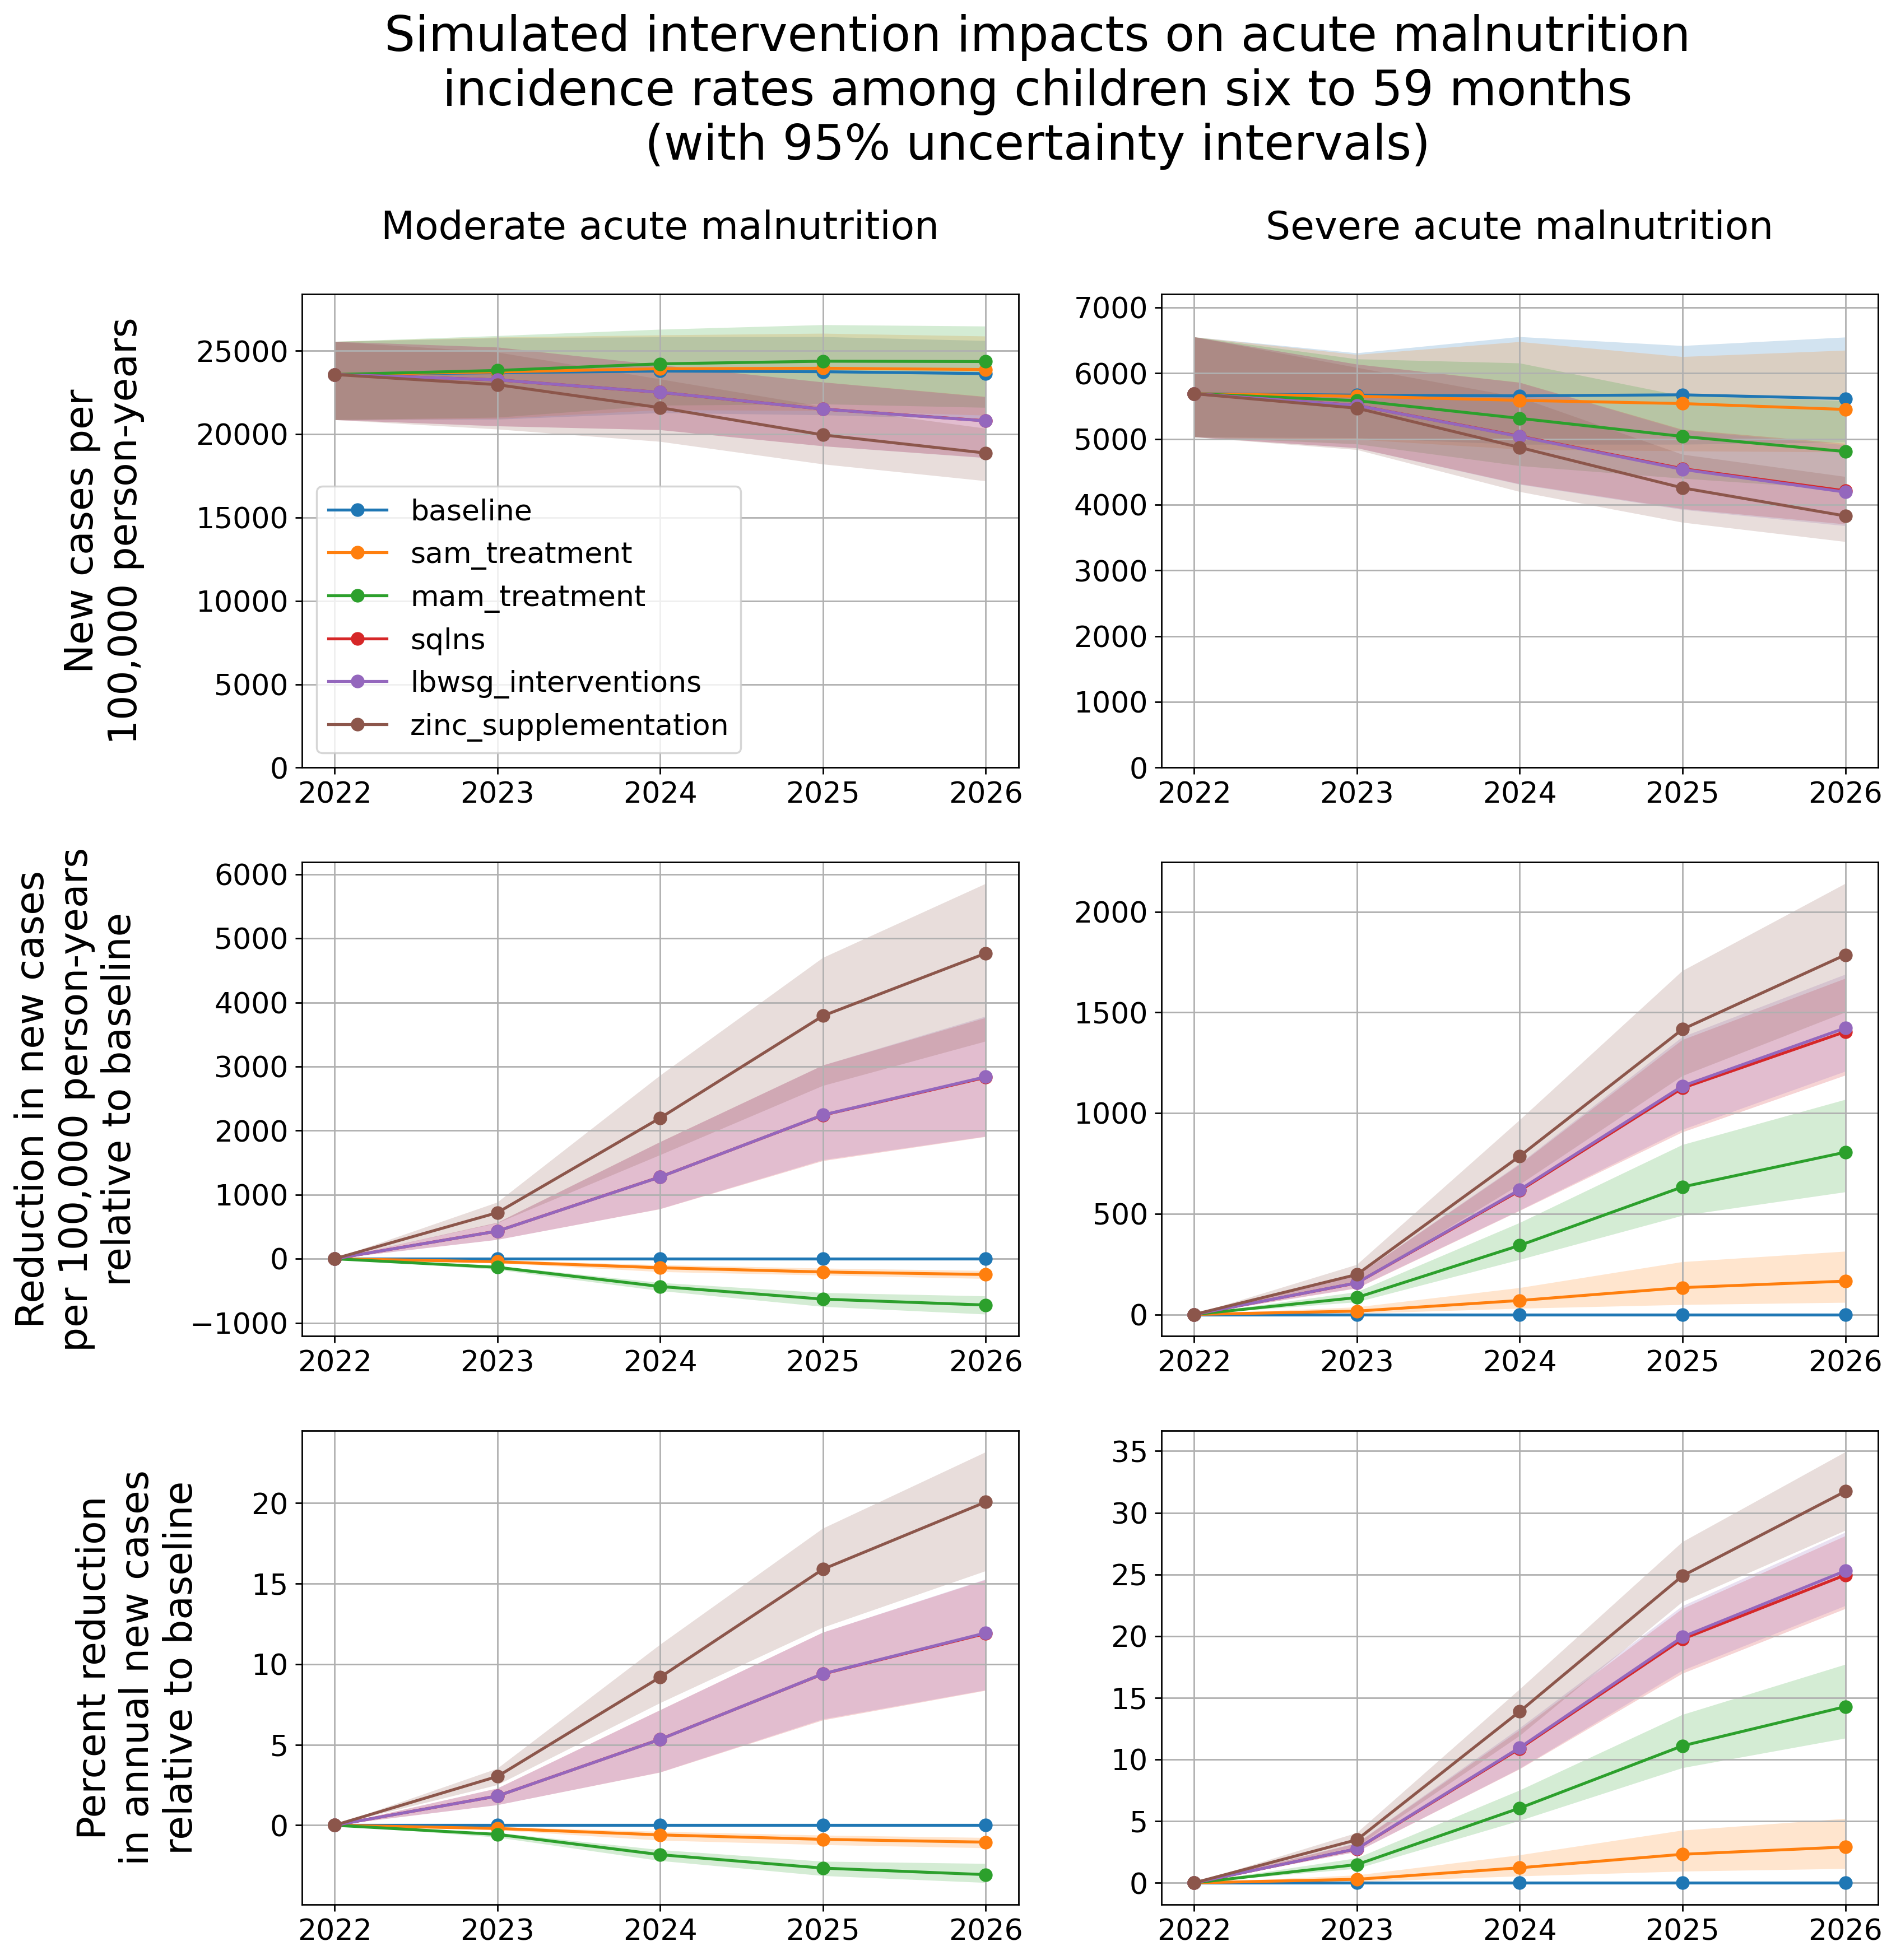

In [14]:
causes = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count',
          #'total_mam',
          #'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'
         ]

cause_titles = ['Moderate acute malnutrition\n',
                'Severe acute malnutrition\n',
                #'All transitions\ninto MAM\n',
                #'MAM cases from\nspontaneous\nSAM recovery'
               ]
metrics = ['value','absolute_reduction','percent_reduction']
metric_titles=['New cases per\n100,000 person-years\n',
              'Reduction in new cases\nper 100,000 person-years\nrelative to baseline\n',
              'Percent reduction\nin annual new cases\nrelative to baseline\n']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'incidence', 
                                        metric, 
                                        'baseline')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        for i in ['baseline','sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']:
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if causes.index(cause)==0:
            pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
            if metrics.index(metric)==0:
                pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                      #bbox_to_anchor=[0.25,4.15], 
                       fontsize=15)
        if metrics.index(metric)==0:
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)',
             y=len(metrics)+.5,x=1,size=25)

# Finding 3: relative to alternative scenario 1

In [36]:
t = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'prevalence', 
                                        'percent_reduction', 
                                        'wasting_treatment')
t = t.loc[(t.year==2026)&(t.scenario!='baseline')]
t['result'] = (t['value','mean'].round(1).astype(str)
              + ' ('
              + t['value','2.5%'].round(1).astype(str)
              + ', '
              + t['value','97.5%'].round(1).astype(str)
              + ')')
t = t.set_index(['scenario','cause']).unstack()[['result']].reset_index()
t['scenario_order'] = np.where(t.scenario=='baseline',0,
                              np.where(t.scenario=='wasting_treatment',1,2))
t = t.sort_values(by='scenario_order').drop(columns='scenario_order')
t

<ipython-input-7-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


scenario             result                              \
                                                                             
cause                       mild_child_wasting moderate_acute_malnutrition   
2         wasting_treatment     0.0 (0.0, 0.0)              0.0 (0.0, 0.0)   
0       lbwsg_interventions  -1.9 (-2.4, -1.3)            13.3 (9.7, 16.8)   
1                     sqlns  -1.9 (-2.4, -1.3)            13.3 (9.7, 16.8)   
3      zinc_supplementation  -1.7 (-2.3, -1.1)           16.3 (14.0, 18.8)   

                                                              \
                                                               
cause severe_acute_malnutrition susceptible_to_child_wasting   
2                0.0 (0.0, 0.0)               0.0 (0.0, 0.0)   
0              10.4 (7.3, 13.0)            -1.9 (-2.5, -1.4)   
1              10.4 (7.3, 13.0)            -1.9 (-2.5, -1.4)   
3             13.8 (12.0, 15.9)            -2.5 (-2.9, -2.2)   

                          
                          
cause             wasted  
2         0.0 (0.0, 0.0)  
0       12.9 (9.3, 16.1)  
1       12.9 (9.4, 16.1)  
3      15.9 (13.7, 18.3)

<ipython-input-7-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-7-f3a43aca46bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'


Text(1.5, 2.75, 'Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)')

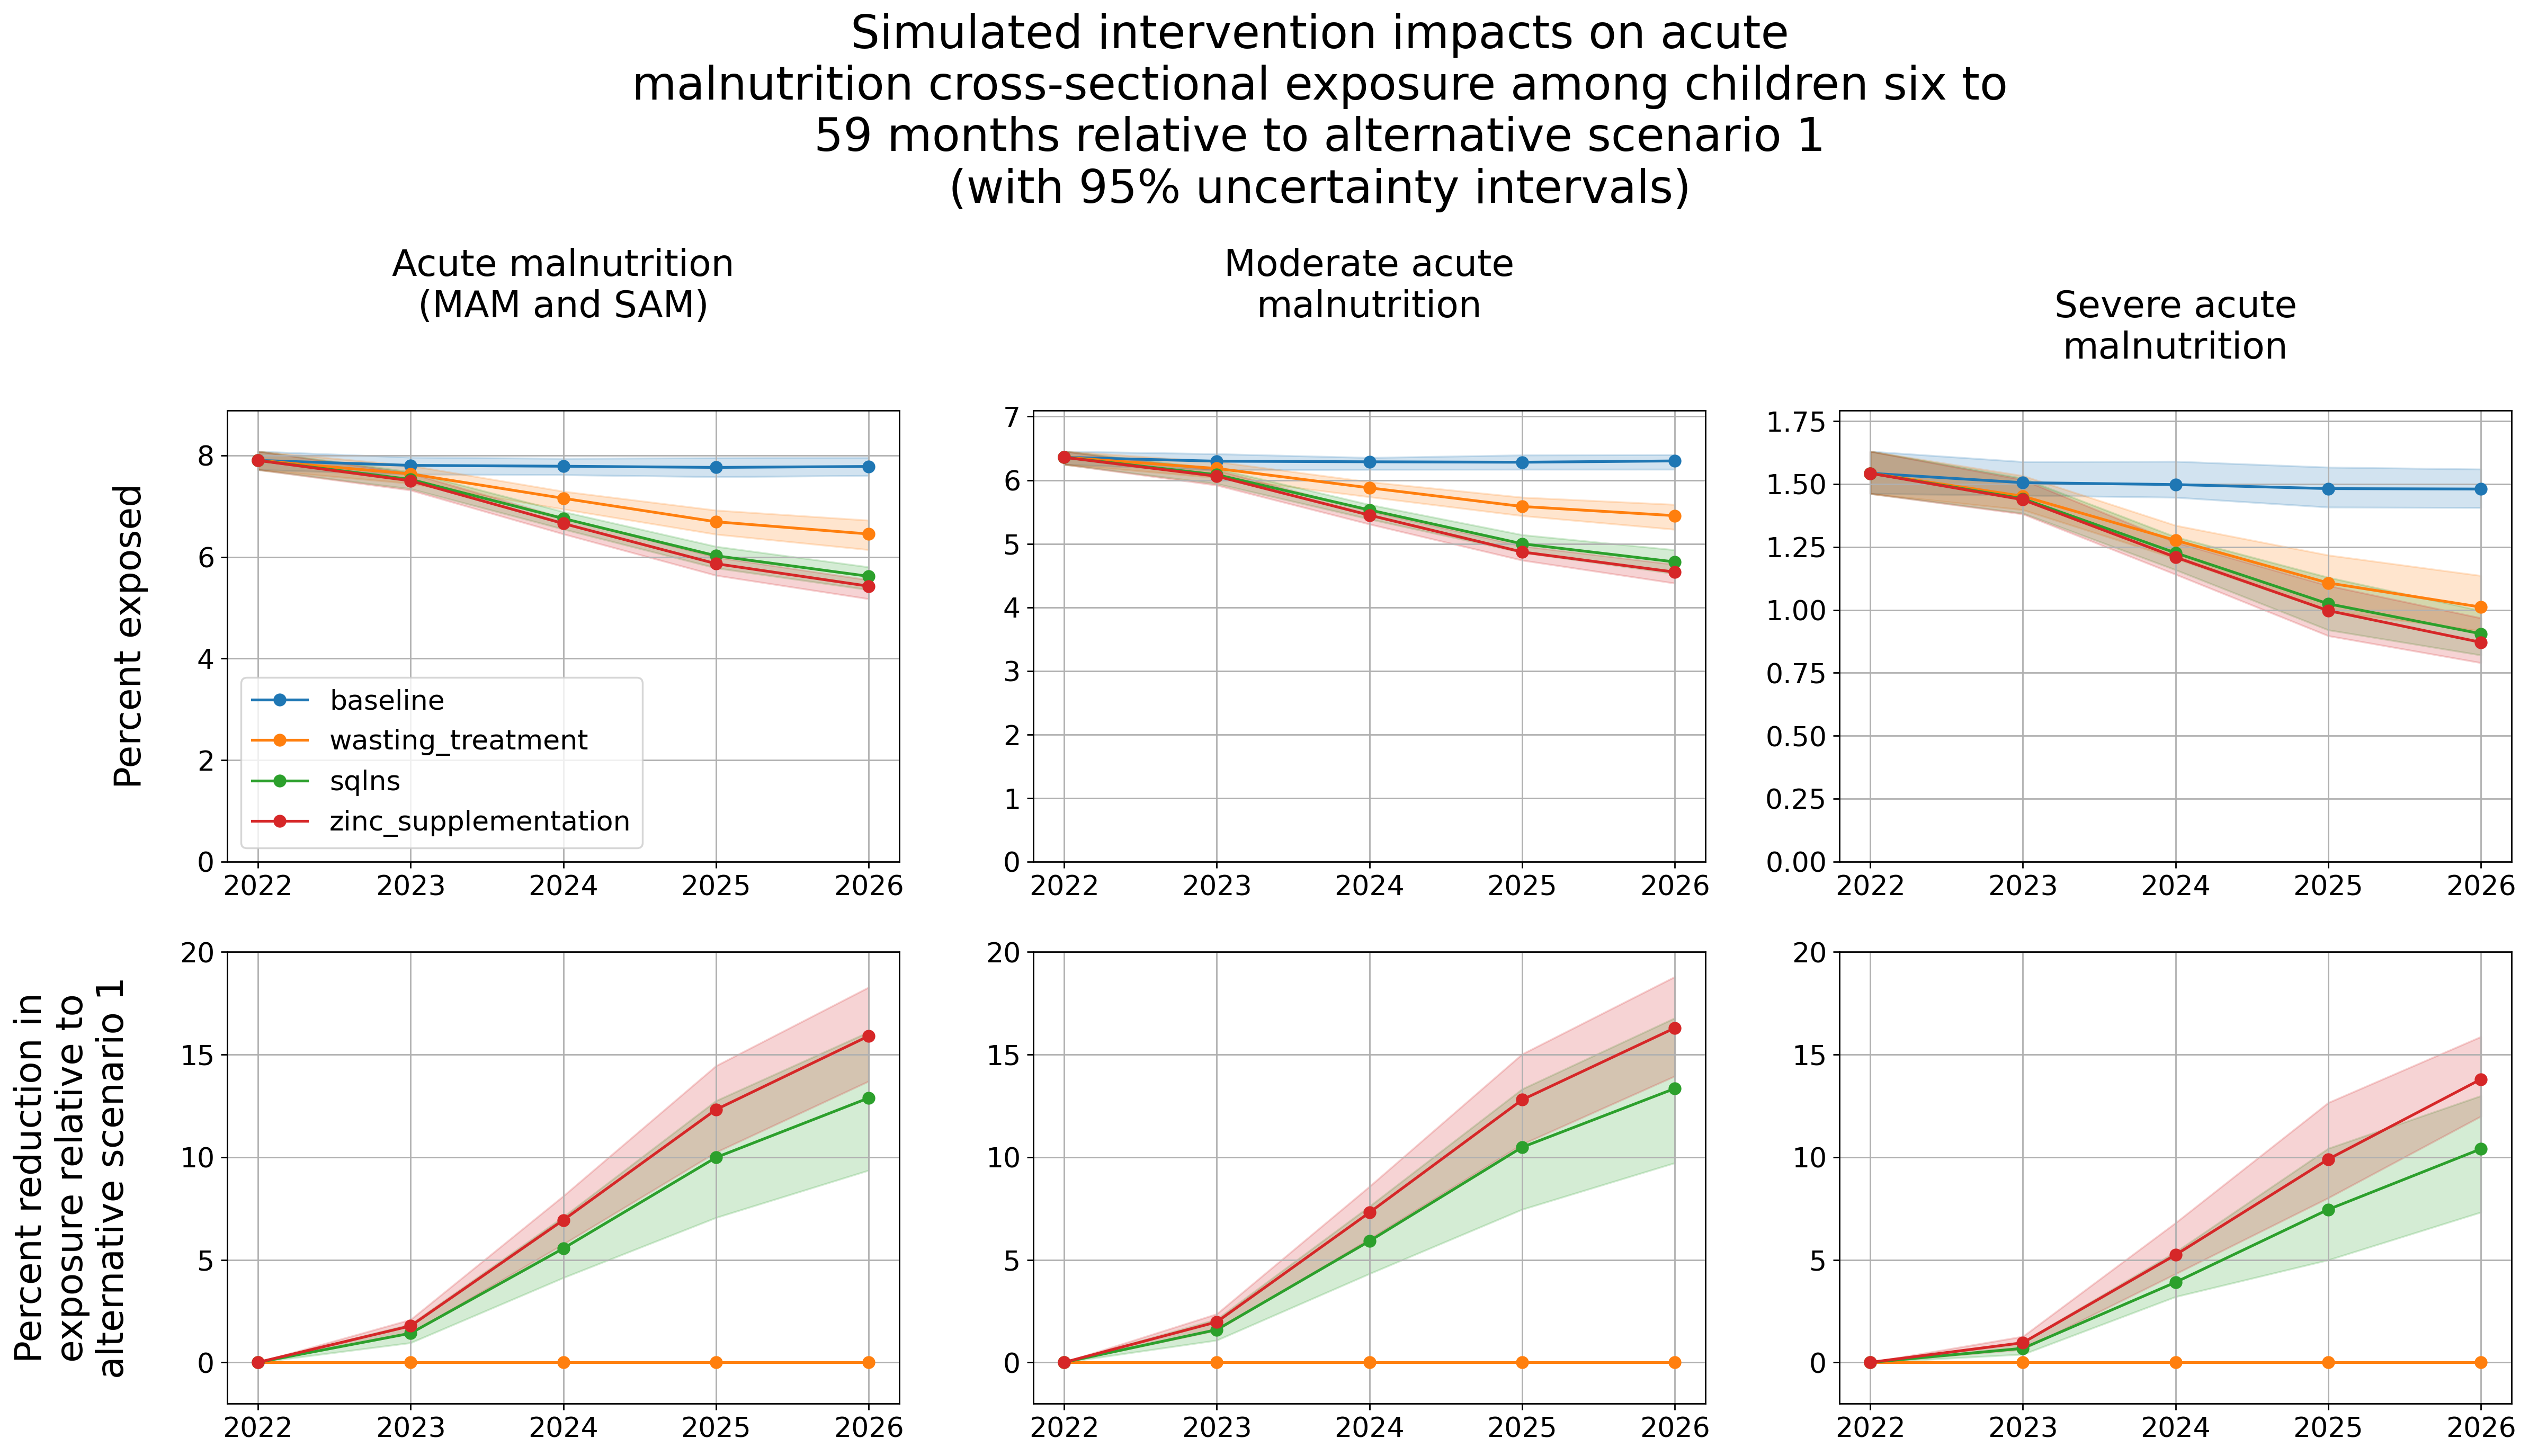

In [39]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'prevalence', 
                                        metric, 
                                        'wasting_treatment')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]  
        if metric=='value':
            scenarios = ['baseline','wasting_treatment','sqlns','zinc_supplementation']
        else:
            scenarios = ['wasting_treatment','sqlns','zinc_supplementation']
        for i in scenarios:
            if i =='baseline':
                color='tab:blue'
            elif i == 'wasting_treatment':
                color='tab:orange'
            elif i == 'sqlns':
                color='tab:green'
            elif i == 'zinc_supplementation':
                color = 'tab:red'
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i, c=color)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2, color=color)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if metrics.index(metric)==0:
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent exposed\n',size=20)
                pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                       fontsize=15)
        if metric=='percent_reduction':
            pos.set_ylim(-2,20)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent reduction in\nexposure relative to\nalternative scenario 1\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)',
             y=2.75,x=1.5,size=25)

In [77]:
t = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'incidence', 
                                        'absolute_reduction', 
                                        'wasting_treatment')
t = t.loc[(t.year==2026)&(t.scenario=='sqlns')]
t['result'] = (t['value','mean'].round(0).astype(int).astype(str)
              + ' ('
              + t['value','2.5%'].round(0).astype(int).astype(str)
              + ', '
              + t['value','97.5%'].round(0).astype(int).astype(str)
              + ')')
t.drop(columns='value')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

scenario                                              cause  year  \
                                                                       
49    sqlns  mild_child_wasting_to_moderate_acute_malnutrit...  2026   
54    sqlns  mild_child_wasting_to_susceptible_to_child_was...  2026   
59    sqlns  moderate_acute_malnutrition_to_mild_child_wast...  2026   
64    sqlns  moderate_acute_malnutrition_to_severe_acute_ma...  2026   
69    sqlns  severe_acute_malnutrition_to_mild_child_wastin...  2026   
74    sqlns  severe_acute_malnutrition_to_moderate_acute_ma...  2026   
79    sqlns  susceptible_to_child_wasting_to_mild_child_was...  2026   
84    sqlns                                          total_mam  2026   
89    sqlns                                             wasted  2026   

                  result  
                          
49     6900 (4869, 8841)  
54  -2874 (-3706, -2038)  
59     6040 (4144, 7782)  
64      1157 (799, 1652)  
69        619 (423, 824)  
74        492 (307, 779)  
79  -2668 (-3465, -1848)  
84     7392 (5213, 9592)  
89    8057 (5668, 10455)

In [76]:
t = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'incidence', 
                                        'percent_reduction', 
                                        'wasting_treatment')
t = t.loc[(t.year==2026)&(t.scenario=='sqlns')]
t['result'] = (t['value','mean'].round(1).astype(str)
              + ' ('
              + t['value','2.5%'].round(1).astype(str)
              + ', '
              + t['value','97.5%'].round(1).astype(str)
              + ')')
t.drop(columns='value')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

scenario                                              cause  year  \
                                                                       
49    sqlns  mild_child_wasting_to_moderate_acute_malnutrit...  2026   
54    sqlns  mild_child_wasting_to_susceptible_to_child_was...  2026   
59    sqlns  moderate_acute_malnutrition_to_mild_child_wast...  2026   
64    sqlns  moderate_acute_malnutrition_to_severe_acute_ma...  2026   
69    sqlns  severe_acute_malnutrition_to_mild_child_wastin...  2026   
74    sqlns  severe_acute_malnutrition_to_moderate_acute_ma...  2026   
79    sqlns  susceptible_to_child_wasting_to_mild_child_was...  2026   
84    sqlns                                          total_mam  2026   
89    sqlns                                             wasted  2026   

               result  
                       
49  15.0 (10.6, 18.8)  
54  -1.1 (-1.4, -0.8)  
59   14.2 (9.8, 18.1)  
64   13.7 (9.7, 17.0)  
69   12.4 (8.9, 15.5)  
74   12.5 (8.6, 15.9)  
79  -1.0 (-1.3, -0.7)  
84  14.8 (10.5, 18.6)  
89  14.8 (10.5, 18.5)

<ipython-input-7-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-7-f3a43aca46bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'
<ipython-input-7-f3a43aca46bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Text(1, 3.6, 'Simulated intervention impacts on acute\nmalnutrition annual incidence among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)')

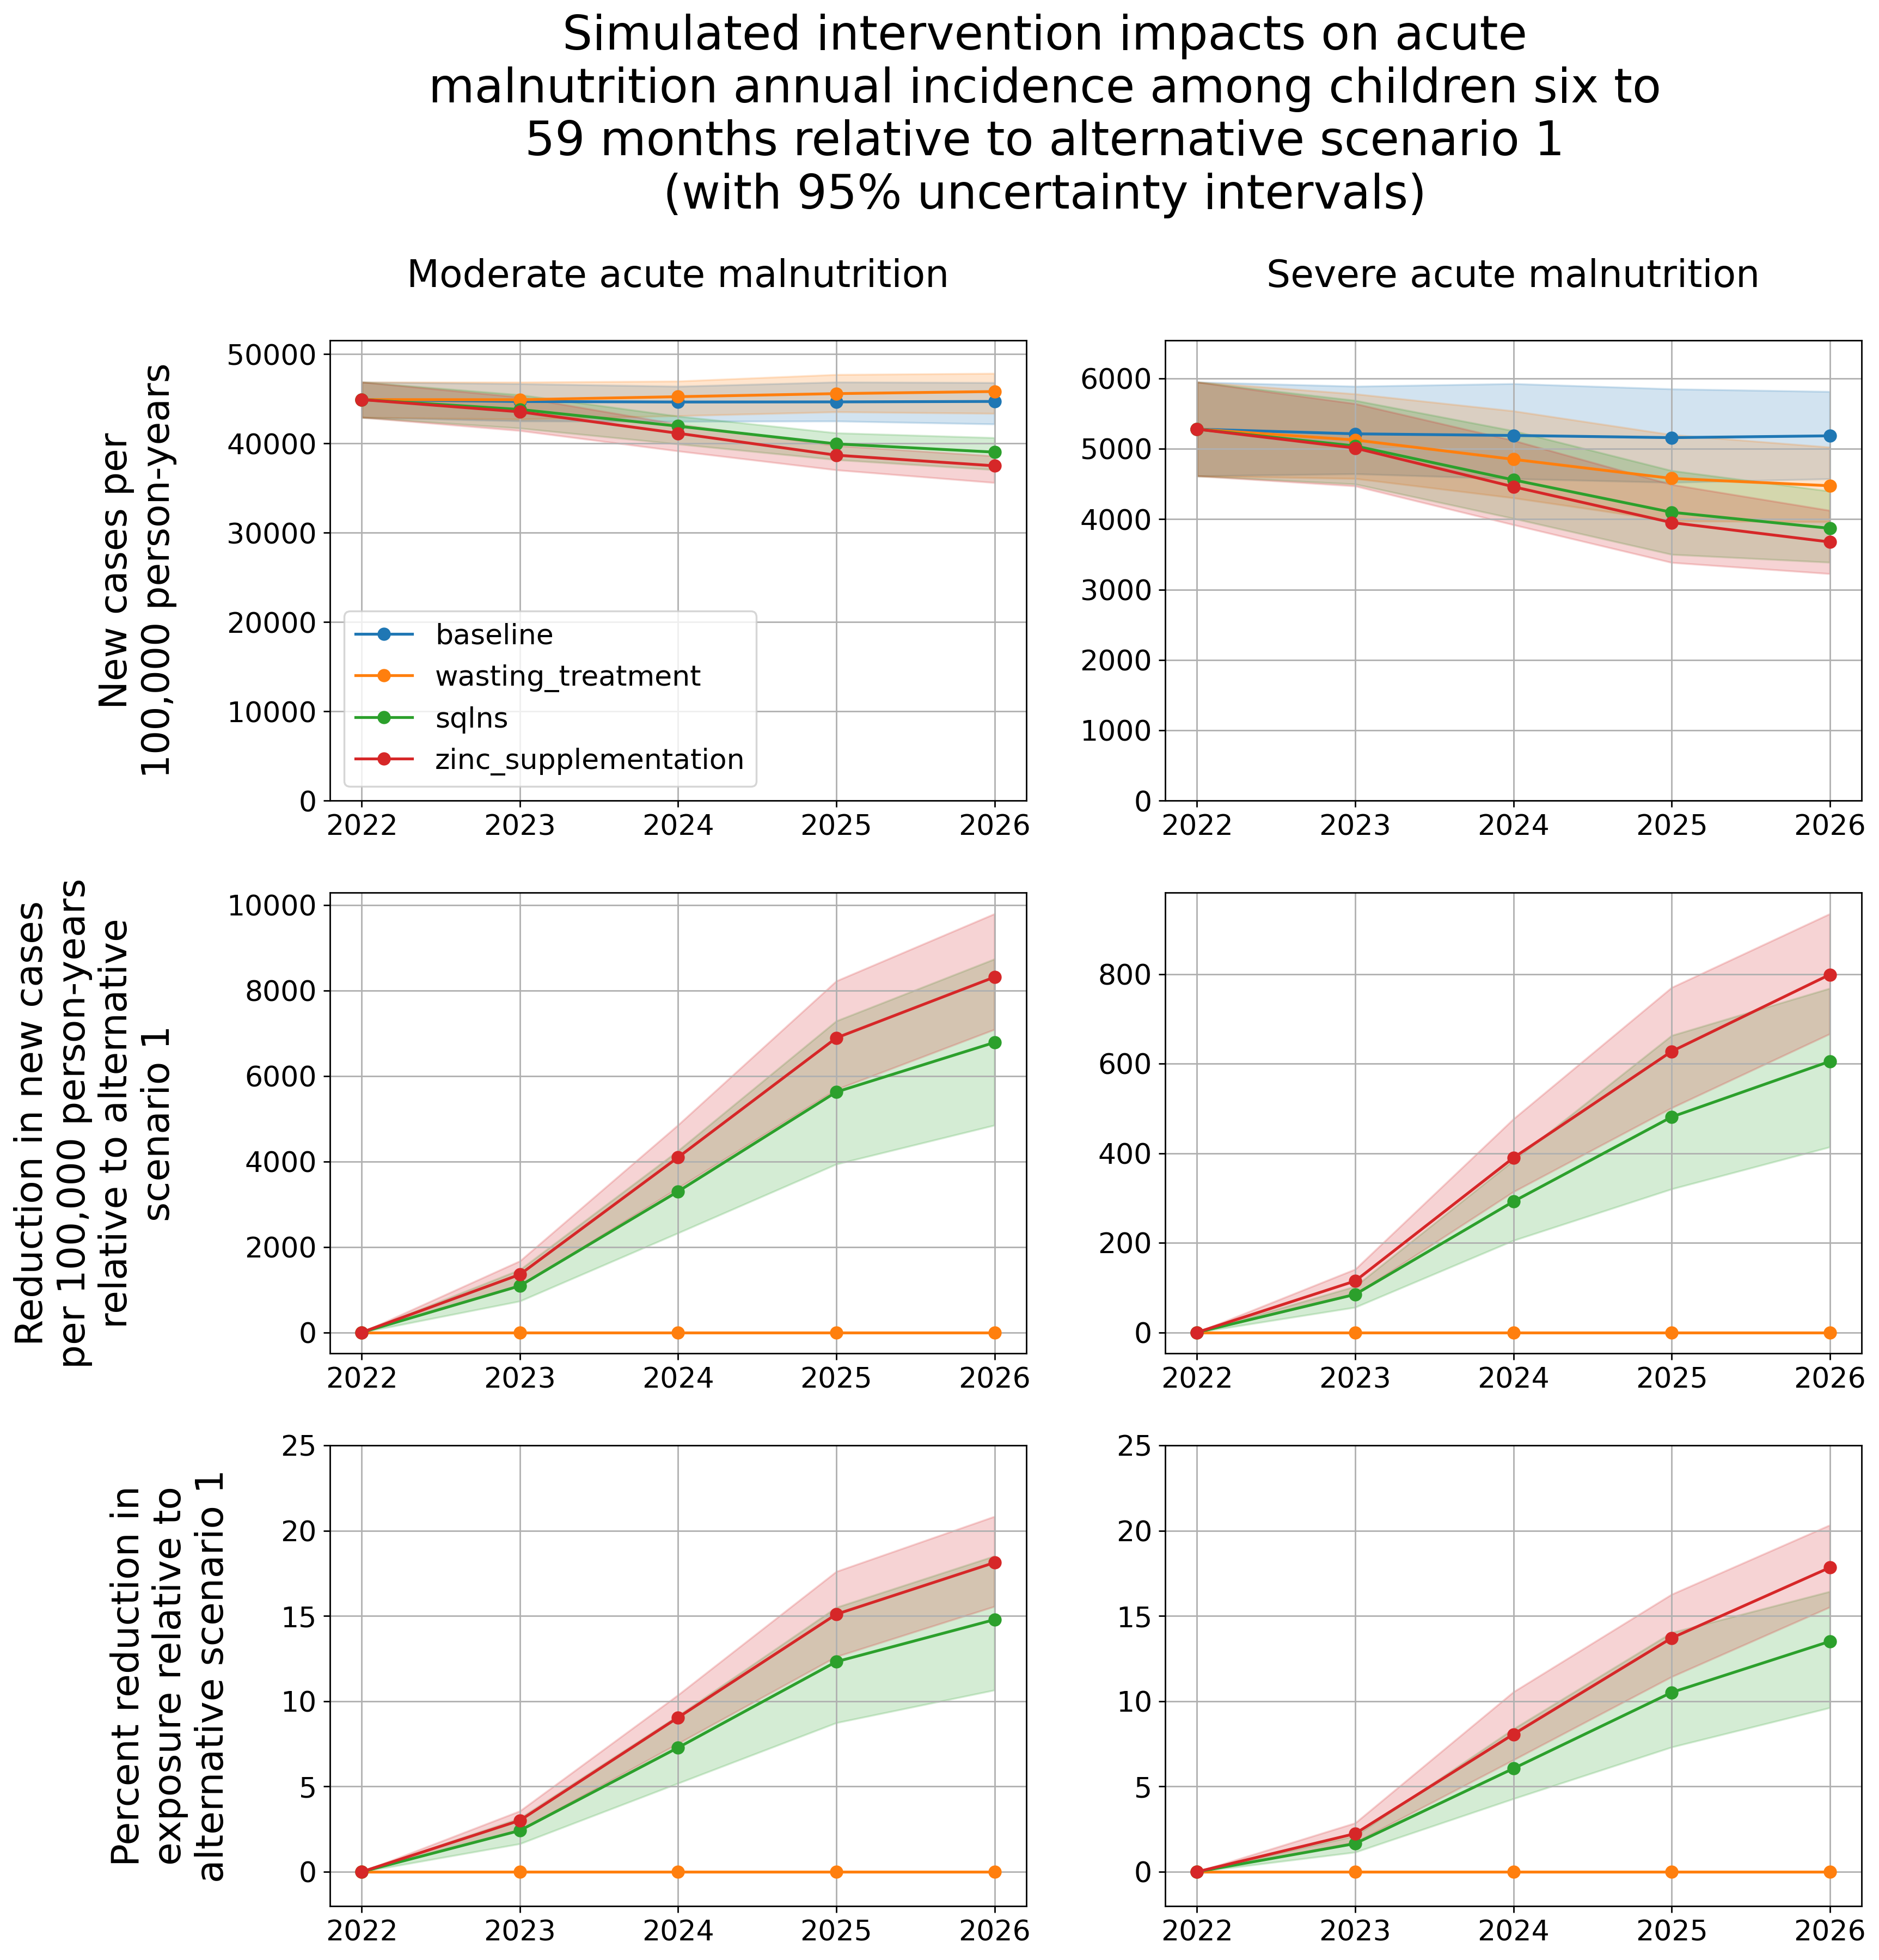

In [42]:
causes = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count',
         ]

cause_titles = ['Moderate acute malnutrition\n',
                'Severe acute malnutrition\n',
               ]
metrics = ['value','absolute_reduction','percent_reduction']
metric_titles=['New cases per\n100,000 person-years\n',
              'Reduction in new cases\nper 100,000 person-years\nrelative to alternative\nscenario 1\n',
              'Percent reduction in\nexposure relative to\nalternative scenario 1\n']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['year'], 
                                        'incidence', 
                                        metric, 
                                        'wasting_treatment')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        if metric=='value':
            scenarios = ['baseline','wasting_treatment','sqlns','zinc_supplementation']
        else:
            scenarios = ['wasting_treatment','sqlns','zinc_supplementation']
        for i in scenarios:
            if i =='baseline':
                color='tab:blue'
            elif i == 'wasting_treatment':
                color='tab:orange'
            elif i == 'sqlns':
                color='tab:green'
            elif i == 'zinc_supplementation':
                color = 'tab:red'
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i, c=color)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2, color=color)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if causes.index(cause)==0:
            pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
            if metrics.index(metric)==0:
                pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                      #bbox_to_anchor=[0.25,4.15], 
                       fontsize=15)
        if metrics.index(metric)==0:
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
        if metric=='percent_reduction':
            pos.set_ylim(-2,25)
            
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute\nmalnutrition annual incidence among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)',
             y=len(metrics)+.6,x=1,size=25)

# Finding 4: stunting exposures

In [14]:
# stunting reduction
def calculate_stunting_values(output_dir, ages, strata_cols, metric, 
                             relative_scenario):
    data = pd.read_csv(output_dir + 'stunting_state_person_time.csv').drop(columns=['Unnamed: 0'])
    stunted = data.loc[data.cause.isin(['cat1','cat2'])]
    groupby_cols = ['input_draw','scenario','cause']
    stunted = (stunted.groupby([c for c in stunted.columns if c != 'cause' and c != 'value']).sum())
    stunted['cause'] = 'stunted'
    data = pd.concat([data,stunted.reset_index()],ignore_index=True)
    data = data.loc[data.age.isin(ages)]
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    if metric=='value':
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
        
    return data[['value']].reset_index()

In [16]:
def plot_values_by_year(data,
                          title, 
                          ylabel,
                          legend=True):
    plt.figure(dpi=120)
    p = data.copy()
    for i in ['baseline','sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']:
        p_sub = p.loc[p.scenario==i]
        plt.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
        plt.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
    if legend==True:
        plt.legend(#['Baseline',
                #'Wasting treatment scale-up',
                #'SQ-LNS and wasting treatment scale-up'],
              fontsize=13)
    plt.xticks(p.year.unique(),size=14)
    plt.yticks(size=14)
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,p['value','97.5%'].max()*1.12)
    plt.grid()
    plt.title(title, size=18)

In [81]:
b = calculate_stunting_values(output_dir, six_to_59_ages, ['year'], 'value', 
                             'baseline')
b = b.loc[b.year==2026]
b['result'] = (b['value','mean'].round(1).astype(str)
              + ' ('
              + b['value','2.5%'].round(1).astype(str)
              + ', '
              + b['value','97.5%'].round(1).astype(str)
              + ')')
b.loc[b.cause=='cat1'].drop(columns='value')#.pivot_table(index='cause',columns='scenario',values='result')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


scenario cause  year             result
                                                    
4            baseline  cat1  2026  13.0 (12.2, 13.6)
29              sqlns  cat1  2026  11.3 (10.1, 12.3)
54  wasting_treatment  cat1  2026  13.0 (12.2, 13.6)

In [84]:
b = calculate_stunting_values(output_dir, six_to_59_ages, ['year'], 'percent_reduction', 
                             'baseline')
b = b.loc[b.year==2026]
b['result'] = (b['value','mean'].round(1).astype(str)
              + ' ('
              + b['value','2.5%'].round(1).astype(str)
              + ', '
              + b['value','97.5%'].round(1).astype(str)
              + ')')
b.loc[b.cause=='stunted'].drop(columns='value')#.pivot_table(index='cause',columns='scenario',values='result')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


scenario    cause  year            result
                                                      
24           baseline  stunted  2026    0.0 (0.0, 0.0)
49              sqlns  stunted  2026   8.0 (5.1, 11.7)
74  wasting_treatment  stunted  2026  -0.0 (-0.0, 0.0)

Text(1.5, 2.6, 'Simulated intervention impacts on child stunting\nexposure among children six to 59 months\n(with 95% uncertainty intervals)')

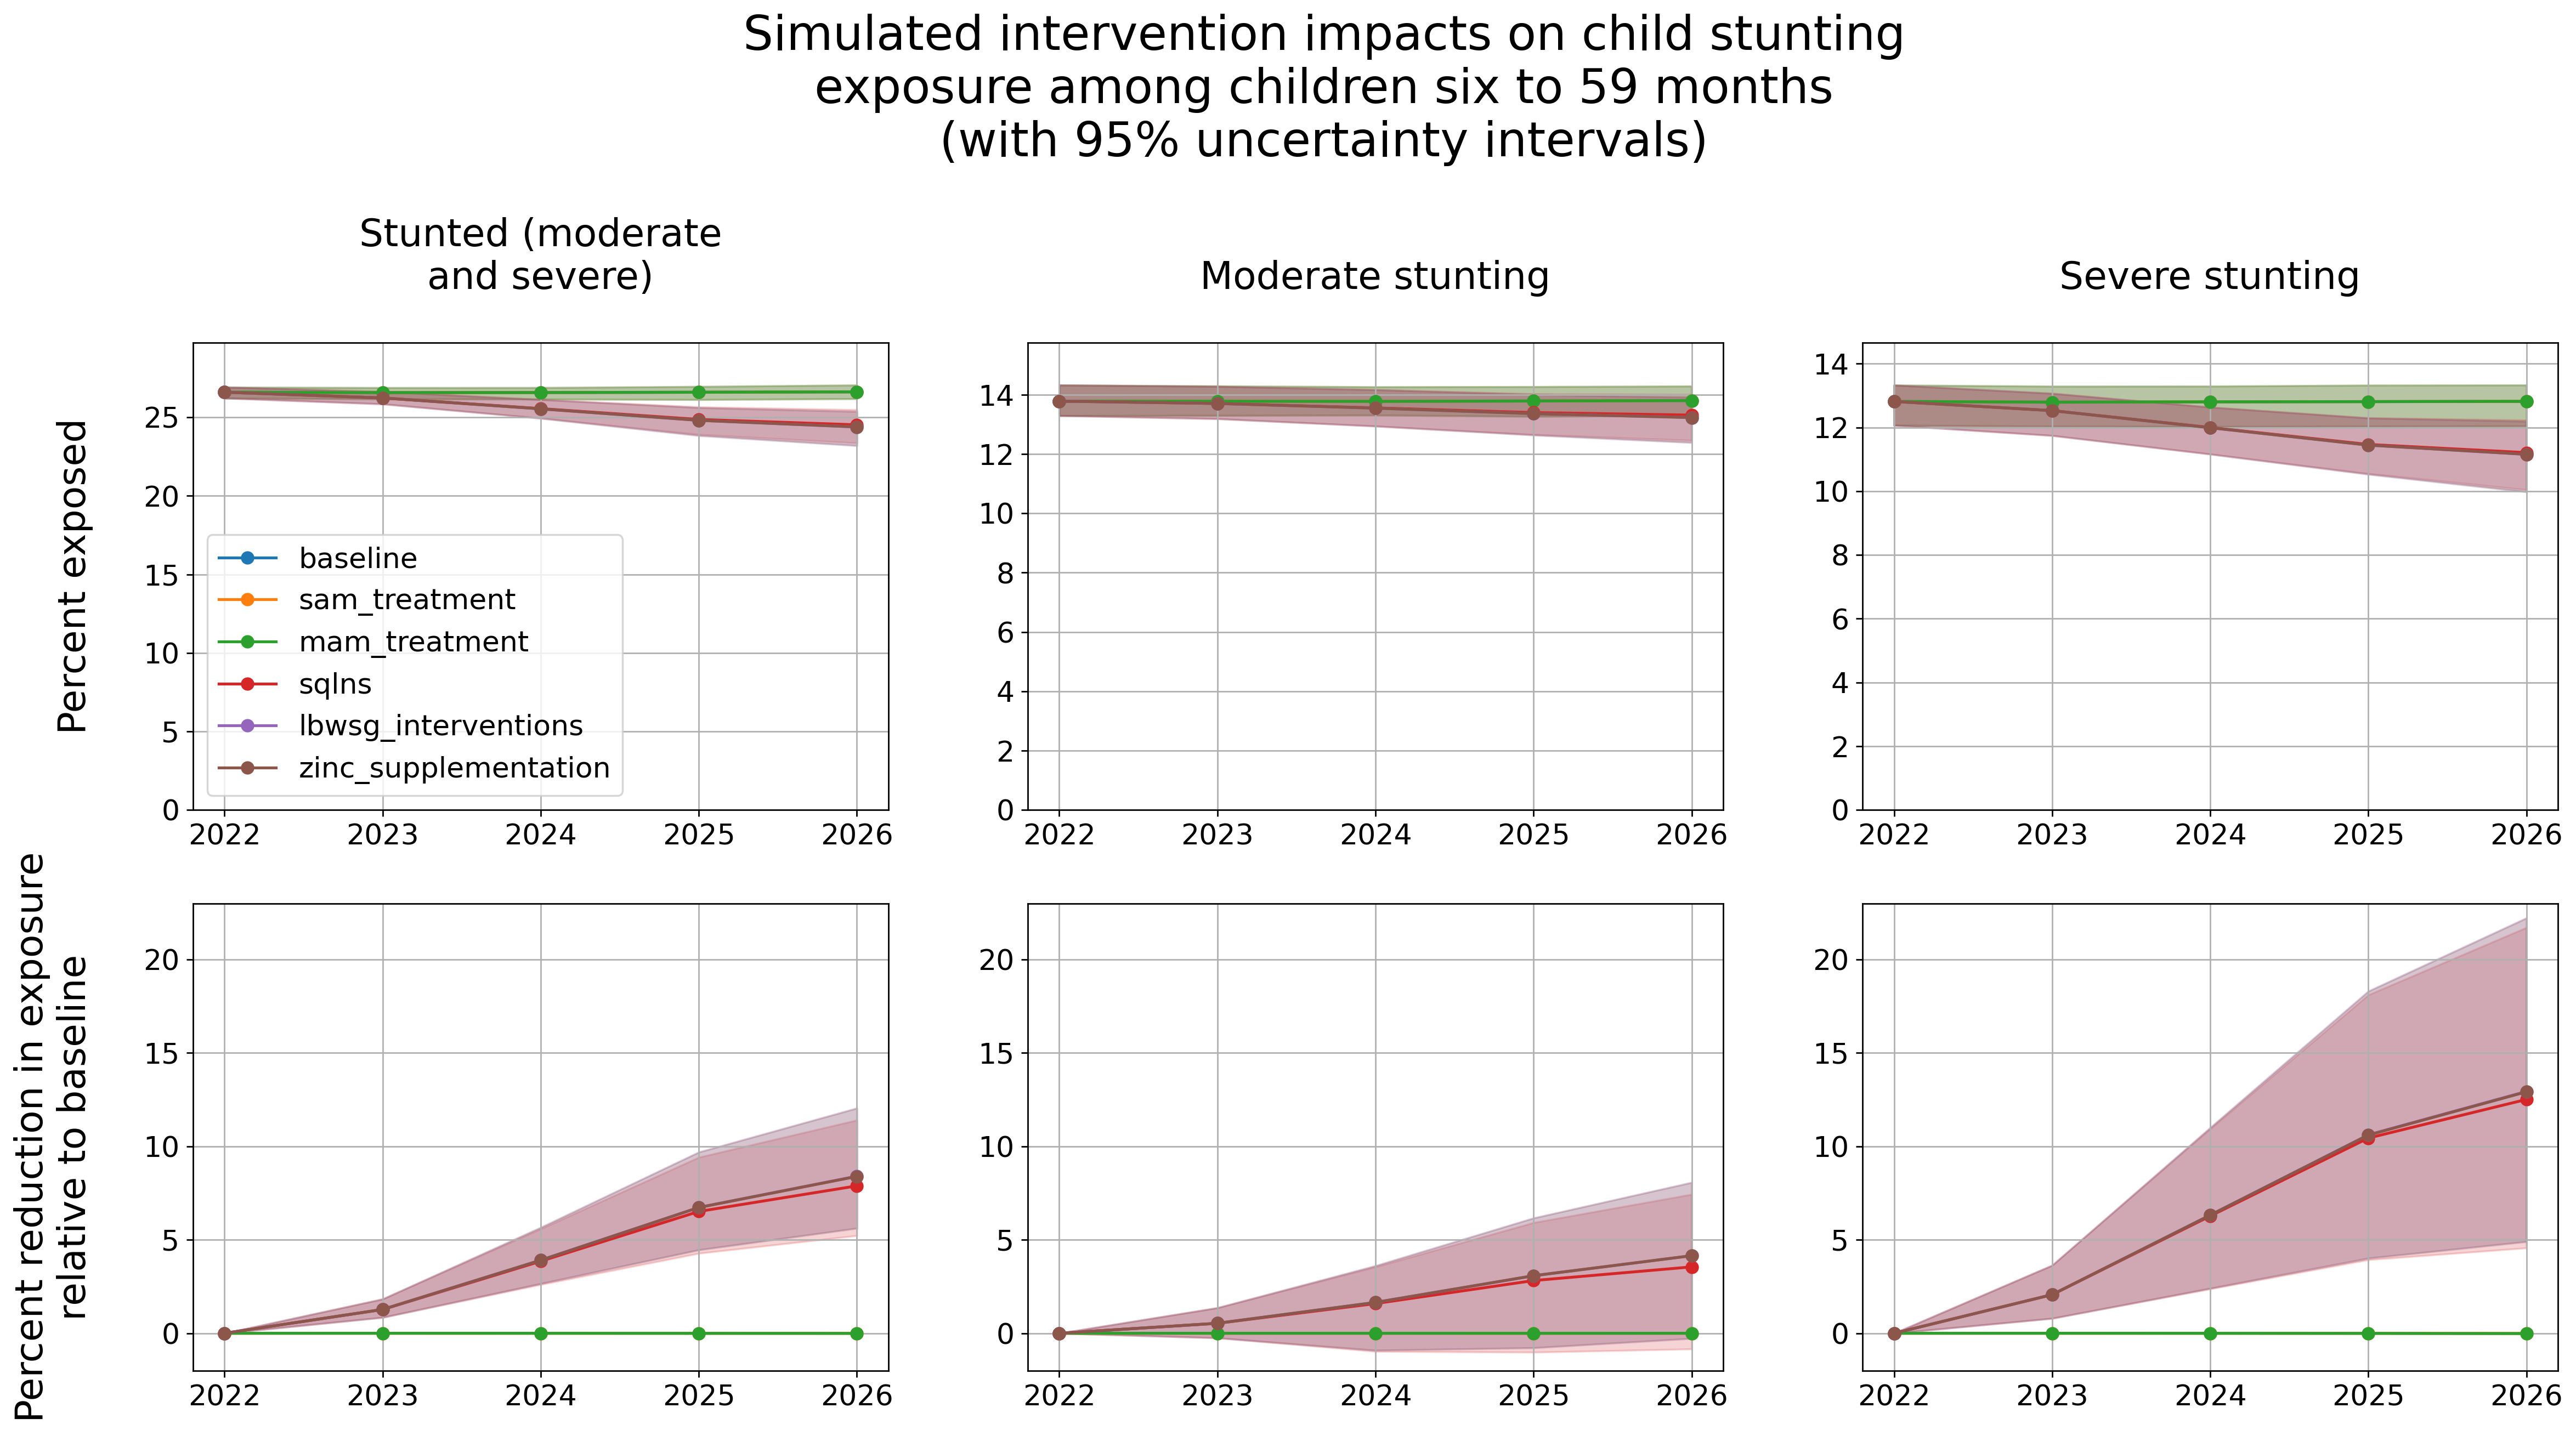

In [19]:
causes = ['stunted',
          'cat2',
          'cat1',]

cause_titles = ['Stunted (moderate\nand severe)\n',
                'Moderate stunting\n',
                'Severe stunting\n'
               ]

metrics = ['value','percent_reduction']

scenario_colors = ['tab:blue','tab:orange','tab:green']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_stunting_values(output_dir, six_to_59_ages, ['year'], 
                                        metric, 
                                        'baseline')
    for cause in causes:
        p = data.loc[data.cause==cause]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        
        if metric=='value':
            scenarios = ['baseline','sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']
        else:
            scenarios = ['sam_treatment','mam_treatment','sqlns','lbwsg_interventions','zinc_supplementation']
        for i in scenarios:
            if i =='baseline':
                color='tab:blue'
            elif i == 'sam_treatment':
                color='tab:orange'
            elif i == 'mam_treatment':
                color='tab:green'
            elif i == 'sqlns':
                color = 'tab:red'
            elif i == 'lbwsg_interventions':
                color = 'tab:purple'
            else:
                color='tab:brown'
            p_sub = p.loc[p.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i,
                    c = color)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2,
                            color = color)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if metrics.index(metric)==0:
            pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            pos.set_title(cause_titles[causes.index(cause)],size=20)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent exposed\n',size=20)
                pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                       fontsize=15)
        else:
            pos.set_ylim(-2,23)
            if causes.index(cause)==0:
                pos.set_ylabel('Percent reduction in exposure\nrelative to baseline\n',size=20)


plt.subplots_adjust(right=len(causes), top=len(metrics))
plt.suptitle('Simulated intervention impacts on child stunting\nexposure among children six to 59 months\n(with 95% uncertainty intervals)',
             y=2.6,x=1.5,size=25)

# Finding 5: mortality and morbidity outcomes

In [112]:
# death reduction
# stunting reduction
def calculate_mortality_values(output_dir, ages, strata_cols, metric, 
                             relative_scenario, measure):
    if measure == 'dalys':
        ylls = pd.read_csv(output_dir + 'ylls.csv').drop(columns=['Unnamed: 0','measure'])
        ylds = pd.read_csv(output_dir + 'ylds.csv').drop(columns=['Unnamed: 0','measure'])
        data = pd.concat([ylls,ylds]).groupby([c for c in ylls.columns if c != 'value' and c != 'cause']).sum().reset_index()
    else:
        data = pd.read_csv(output_dir + f'{measure}.csv').drop(columns=['Unnamed: 0'])
    pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
    groupby_cols = ['input_draw','scenario']
    data = data.loc[data.age.isin(ages)]
    pt = pt.loc[pt.age.isin(ages)]
    data = (data.groupby(['input_draw','scenario'] + strata_cols).sum()
            / pt.groupby(['input_draw','scenario'] + strata_cols).sum()
            * 100_000)
    if metric=='val':
        data = (data.groupby(['scenario'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
        
    return data[['value']].reset_index()

In [120]:
b = calculate_mortality_values(output_dir, ages, ['year'], 'absolute_reduction', 
                             'wasting_treatment', 'dalys')
b = b.loc[b.year==2026]
b['result'] = (b['value','mean'].round(1).astype(str)
              + ' ('
              + b['value','2.5%'].round(1).astype(str)
              + ', '
              + b['value','97.5%'].round(1).astype(str)
              + ')')
b.drop(columns='value')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


scenario  year                    result
                                                     
4            baseline  2026  -833.4 (-1190.4, -475.7)
9               sqlns  2026     779.4 (487.6, 1188.9)
14  wasting_treatment  2026            0.0 (0.0, 0.0)

In [114]:
b = calculate_mortality_values(output_dir, ages, ['year'], 'val', 
                             'baseline', 'ylls')
b = b.loc[b.year==2026]
b['result'] = (b['value','mean'].round(1).astype(str)
              + ' ('
              + b['value','2.5%'].round(1).astype(str)
              + ', '
              + b['value','97.5%'].round(1).astype(str)
              + ')')
b.drop(columns='value')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


scenario  year                      result
                                                       
4            baseline  2026  40453.2 (30263.1, 47377.0)
9               sqlns  2026  38923.8 (29282.5, 45741.8)
14  wasting_treatment  2026  39667.3 (29760.7, 46308.6)

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/ihme/code/alibow/miniconda/envs/vivarium_ci

Text(2, 3.6, 'Simulated morbidity and mortality outcomes\namong children aged six to 59 months\n(with 95% uncertainty intervals)')

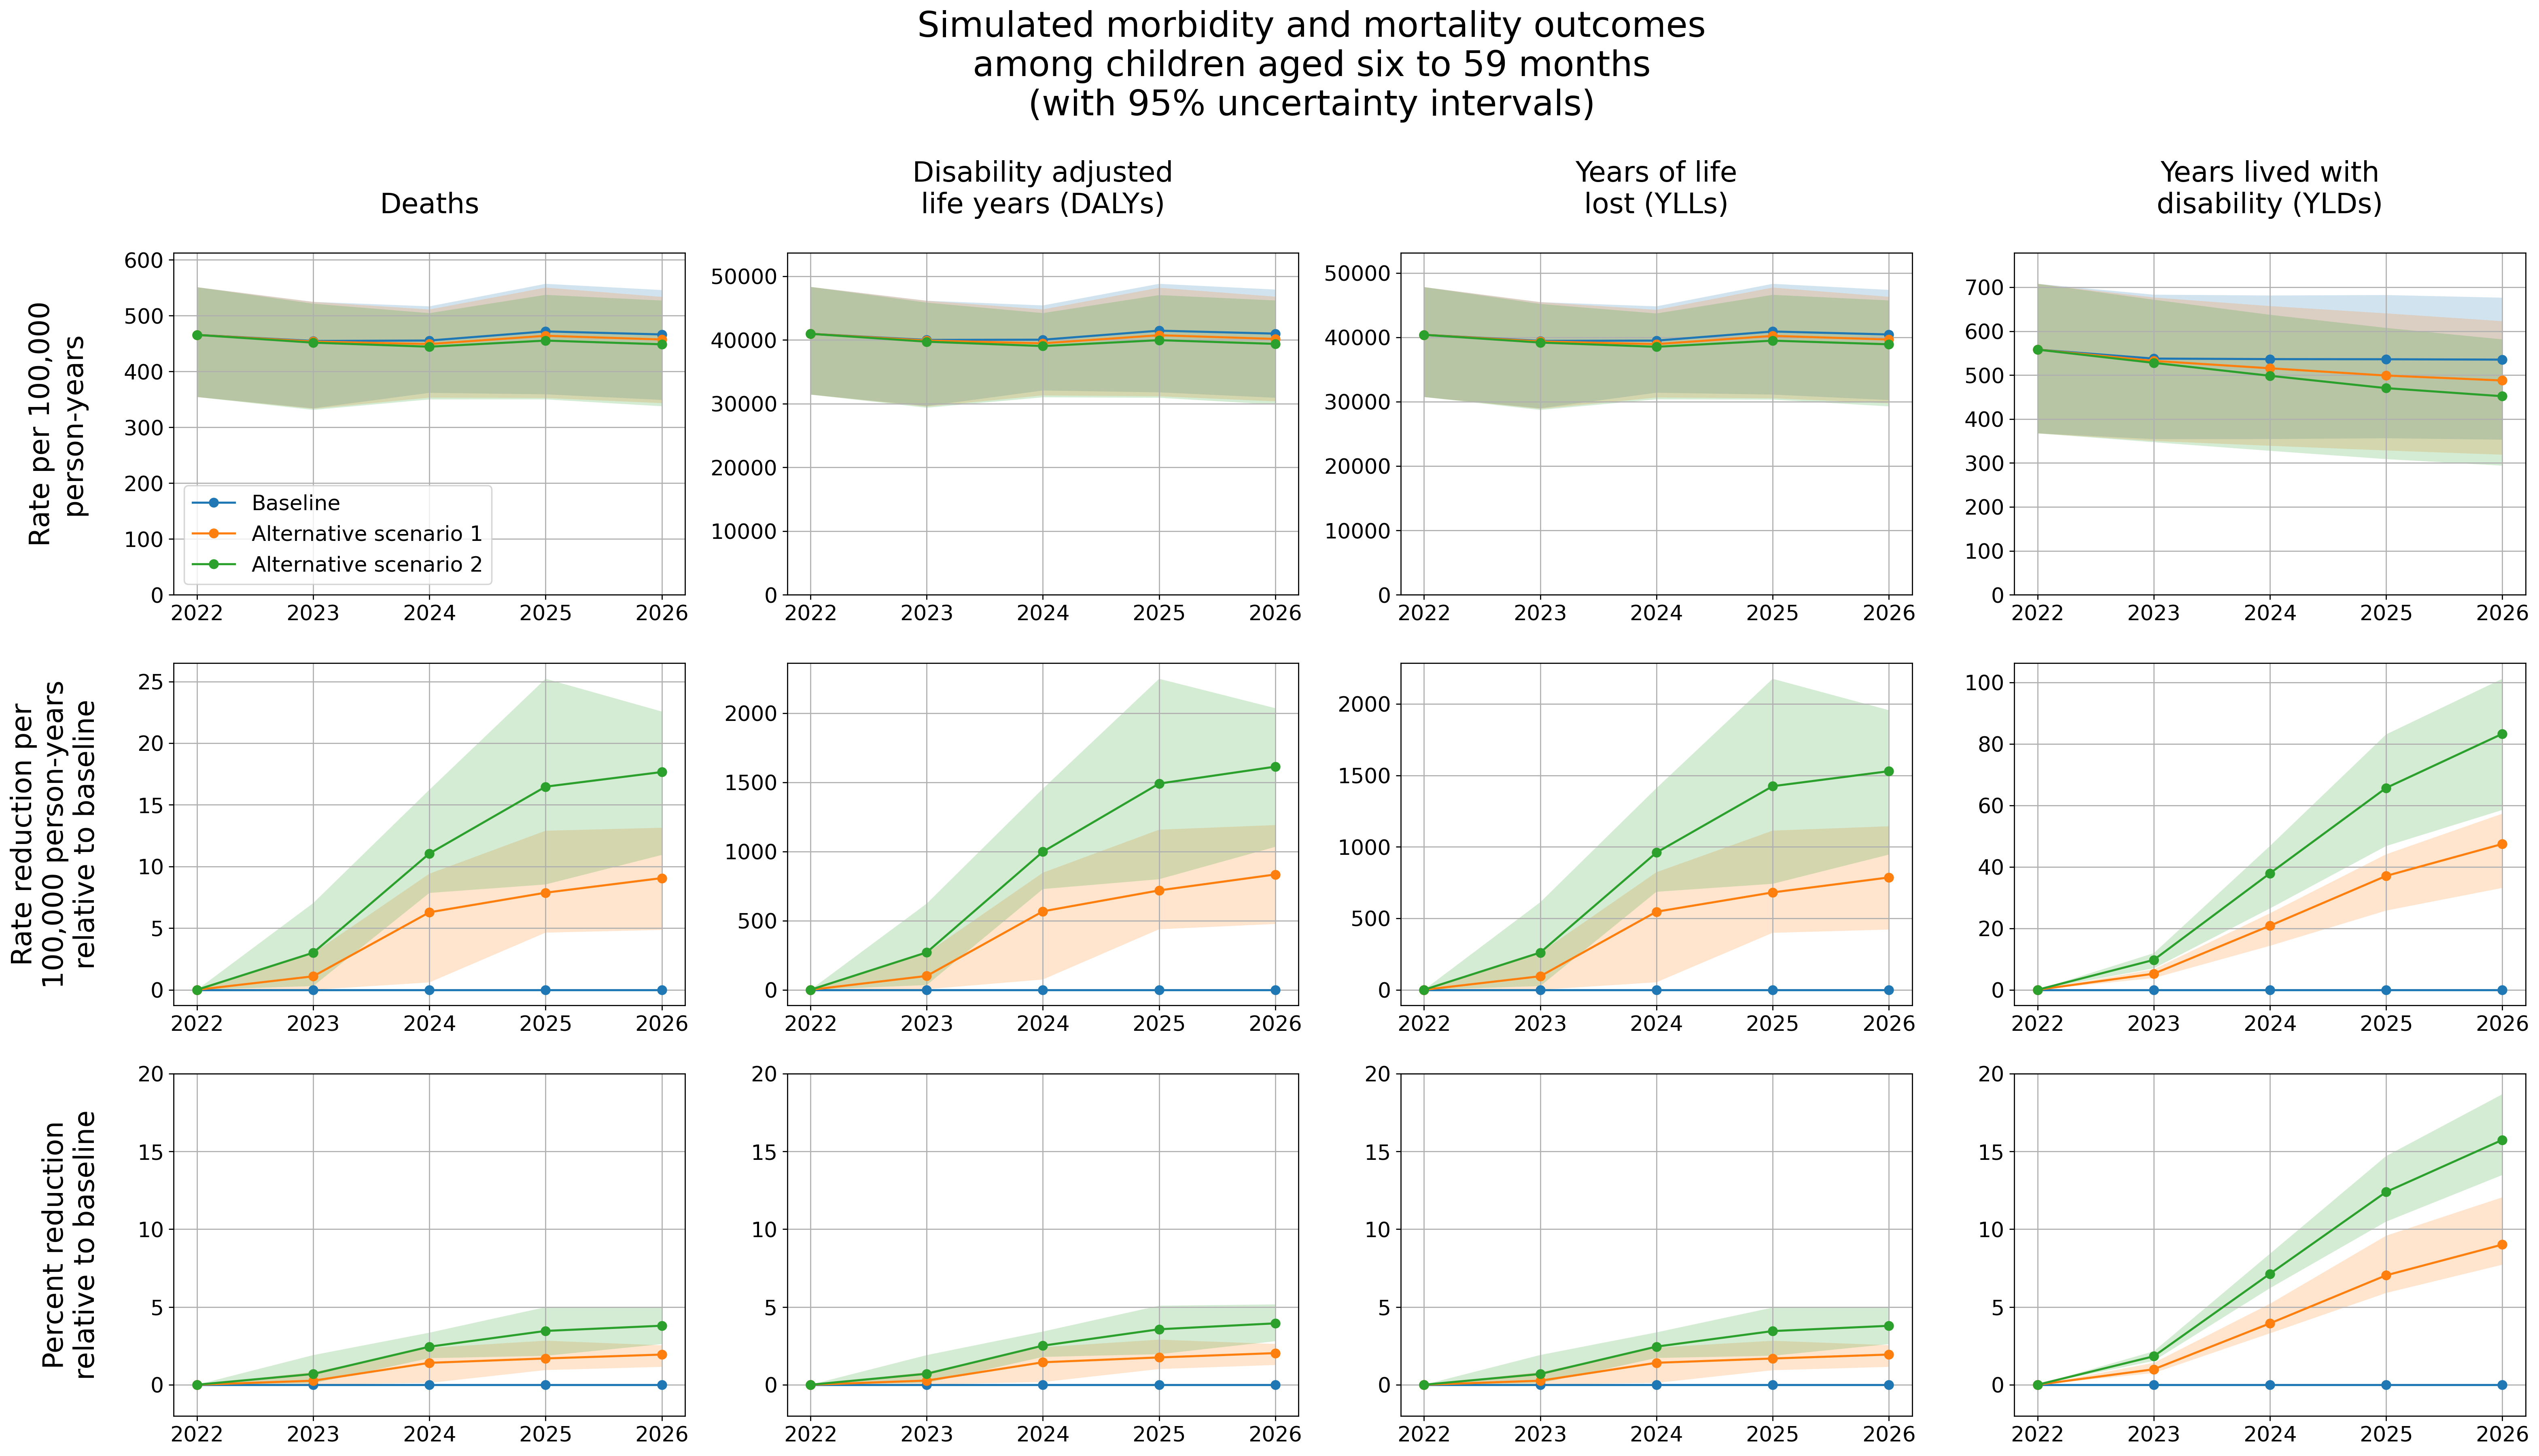

In [115]:
measures = ['deaths',
          'dalys',
          'ylls',
         'ylds']
measure_titles = ['Deaths\n',
                 'Disability adjusted\nlife years (DALYs)\n',
                 'Years of life\nlost (YLLs)\n',
                 'Years lived with\ndisability (YLDs)\n']

metrics = ['val','absolute_reduction','percent_reduction']
metric_titles = ['Rate per 100,000\nperson-years\n',
                 'Rate reduction per\n100,000 person-years\nrelative to baseline\n',
                 'Percent reduction\nrelative to baseline\n'
                ]

fig, axs = plt.subplots(len(metrics), 
                        len(measures),
                        dpi=250)
for metric in metrics:
    for measure in measures:
        data = calculate_mortality_values(output_dir, ages, ['year'], metric, 
                             'baseline', measure)
        pos = axs[metrics.index(metric),measures.index(measure)]   
        for i in ['baseline','wasting_treatment','sqlns']:
            p_sub = data.loc[data.scenario==i]
            pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
            pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
        pos.grid()
        pos.set_xticks(p_sub.year.unique())
        pos.set_xticklabels(p_sub.year.unique(),Fontsize=15)
        pos.tick_params(axis='y', labelsize=15)
        if metrics.index(metric)==0:
            pos.set_title(measure_titles[measures.index(measure)],size=20)
            pos.set_ylim(0,data.loc[data.scenario=='baseline']['value','97.5%'].max()*1.1)
            if measures.index(measure)==0:
                pos.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'],
                       fontsize=15)
        if measures.index(measure)==0:
            pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
        if metric=='percent_reduction':
            pos.set_ylim(-2,20)
       

plt.subplots_adjust(right=len(measures), top=len(metrics))
plt.suptitle('Simulated morbidity and mortality outcomes\namong children aged six to 59 months\n(with 95% uncertainty intervals)',
             y=3.6,x=2,size=25)

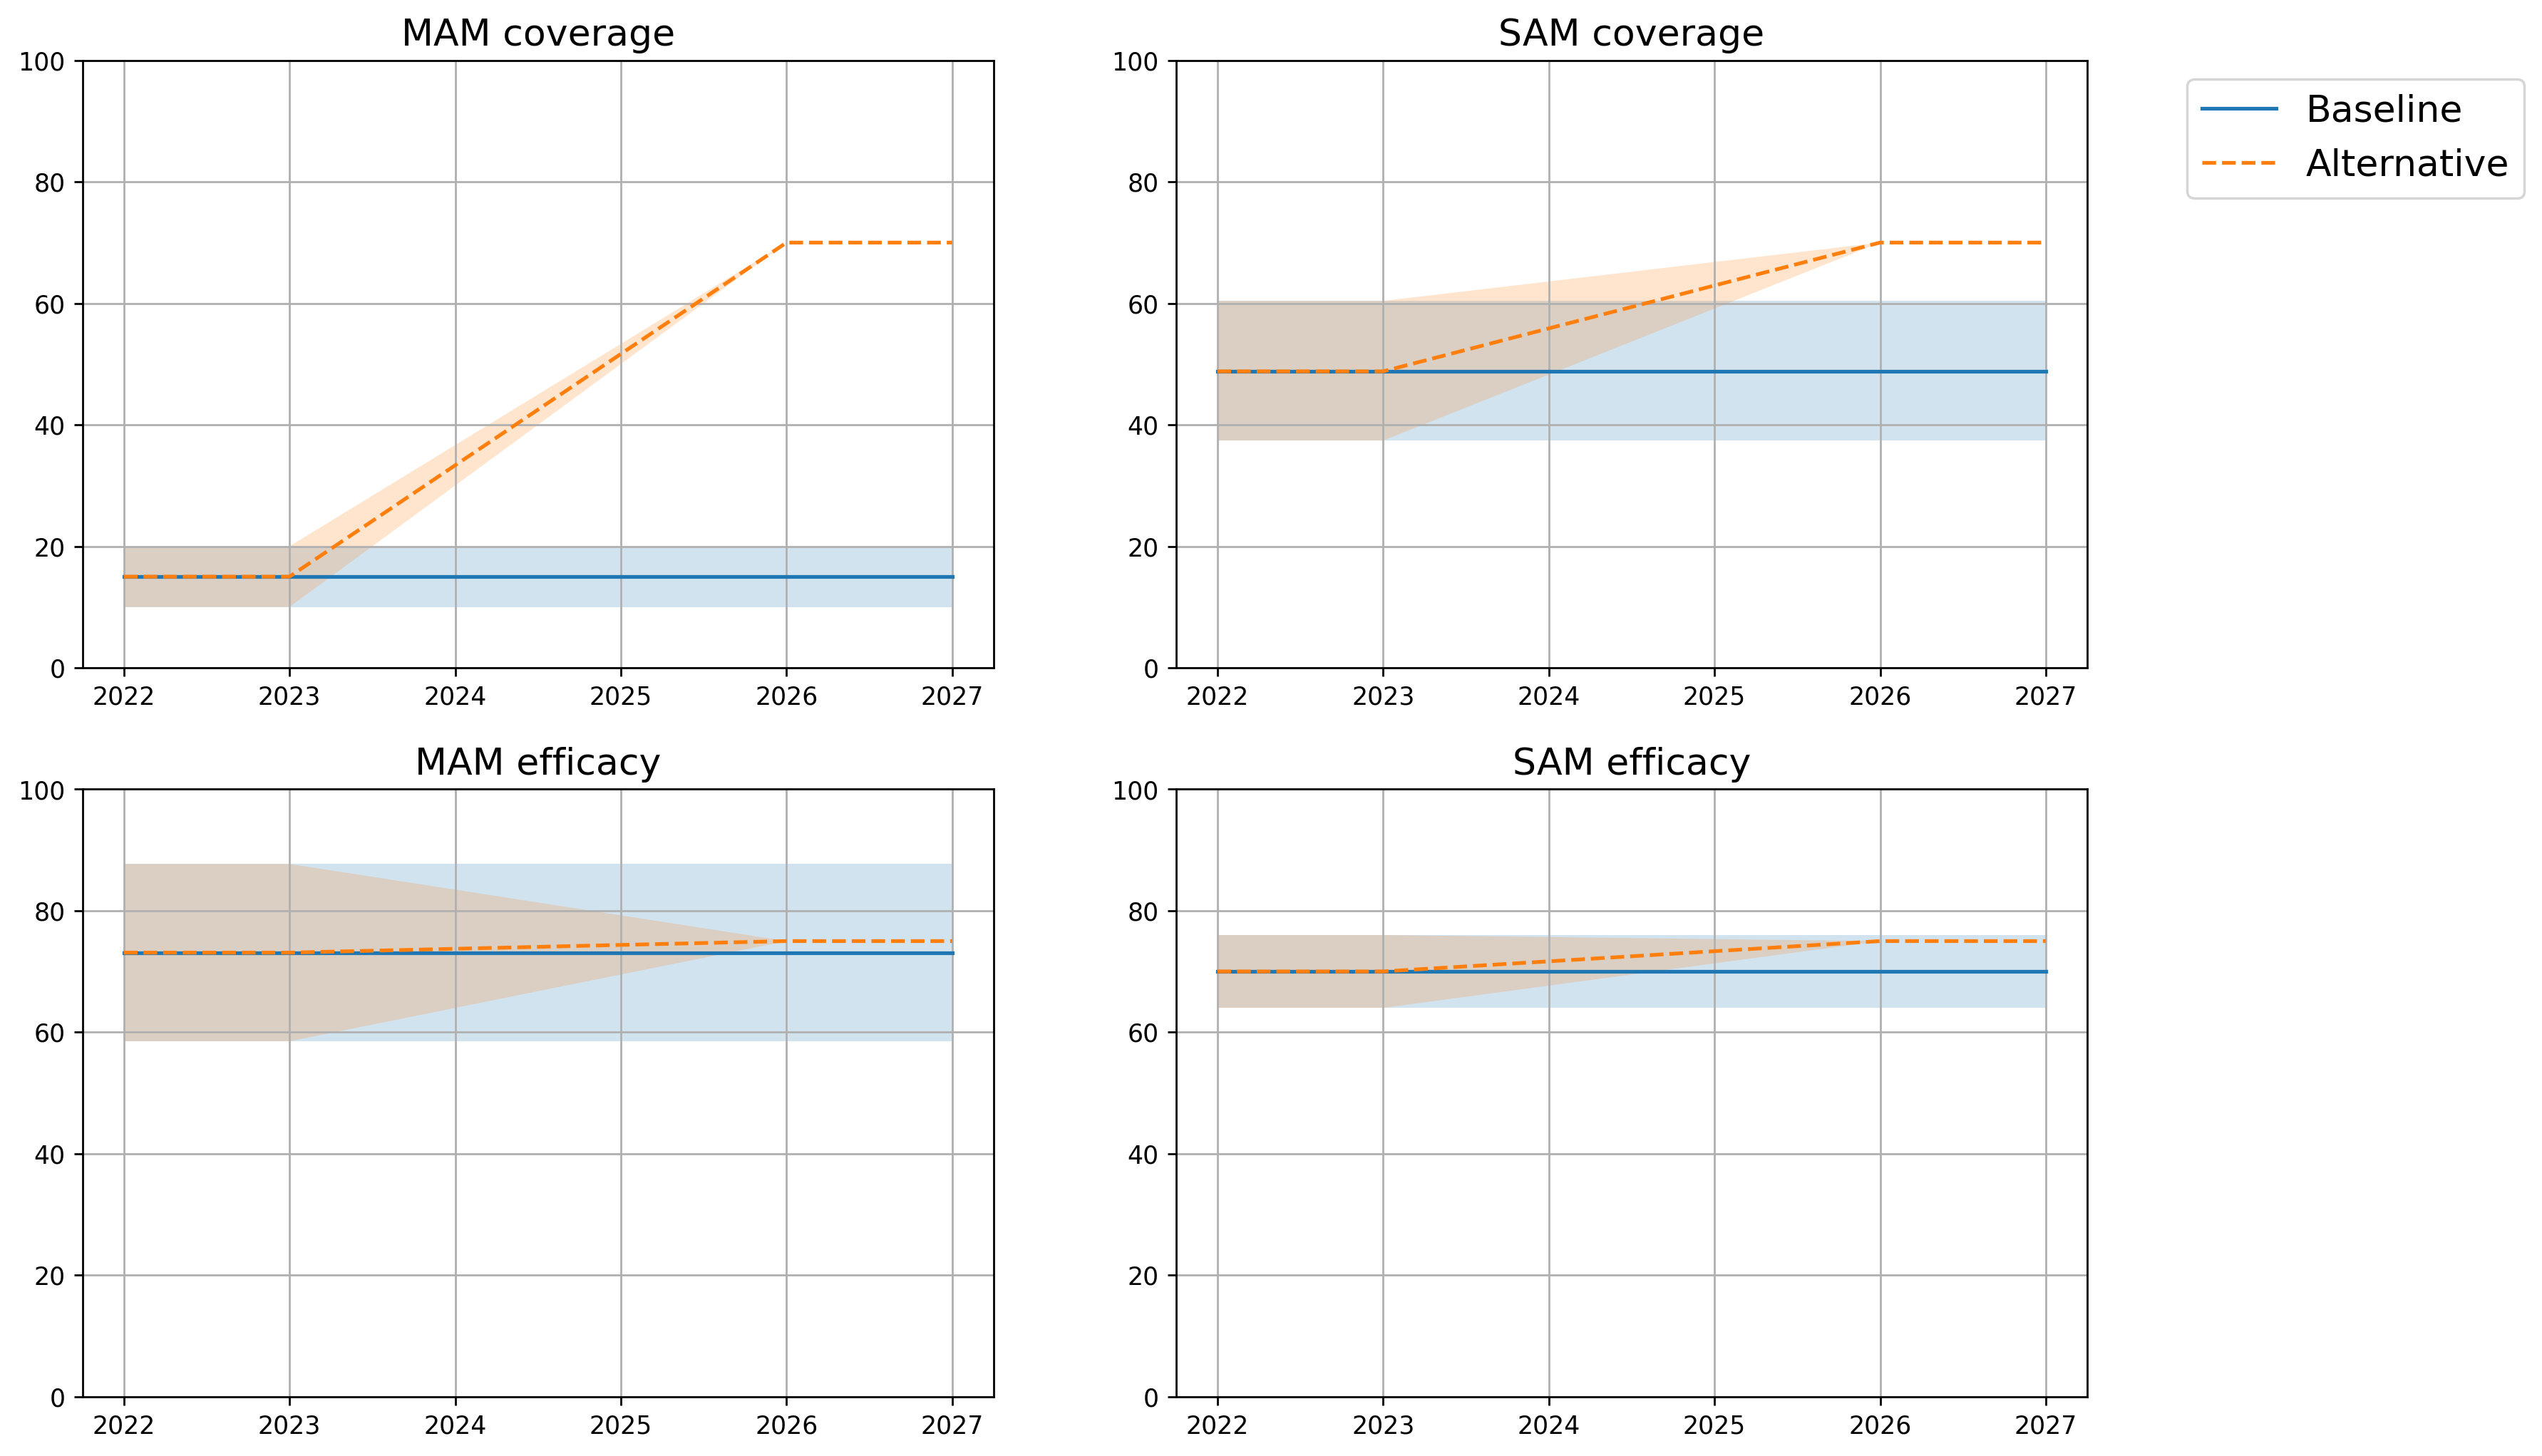

In [13]:
baseline_vals = [15, 48.8, 73.1, 70]
baseline_lcls = [10, 37.4, 58.5, 64]
baseline_ucls = [20, 60.4, 87.7, 76]
targets = [70, 70, 75, 75]
titles = ['MAM coverage',
         'SAM coverage',
         'MAM efficacy',
         'SAM efficacy']
num1s = [0,0,1,1]
num2s = [0,1,0,1]

years = list(range(2022,2028))
fig, axs = plt.subplots(2, 
                        2,
                        dpi=250)

for i in list(range(0,len(baseline_vals))):

    axs[num1s[i],num2s[i]].plot(years,[baseline_vals[i]]*len(years))
    axs[num1s[i],num2s[i]].fill_between(years, [baseline_lcls[i]]*len(years), [baseline_ucls[i]]*len(years),alpha=0.2)
    axs[num1s[i],num2s[i]].plot([2022,2023,2026,2027],[baseline_vals[i],
                                                       baseline_vals[i],
                                                       targets[i],
                                                       targets[i]], linestyle='dashed')
    axs[num1s[i],num2s[i]].fill_between([2022,2023,2026,2027],[baseline_lcls[i],
                                                       baseline_lcls[i],
                                                       targets[i],
                                                       targets[i]],
                                        [baseline_ucls[i],
                                                       baseline_ucls[i],
                                                       targets[i],
                                                       targets[i]],alpha=0.2)
    axs[num1s[i],num2s[i]].grid()
    axs[num1s[i],num2s[i]].set_ylim(0,100)
    axs[num1s[i],num2s[i]].set_title(titles[i],size=15)

plt.legend(['Baseline','Alternative'],bbox_to_anchor=[1.5,2.2],fontsize=15)
plt.subplots_adjust(right=2, top=2)

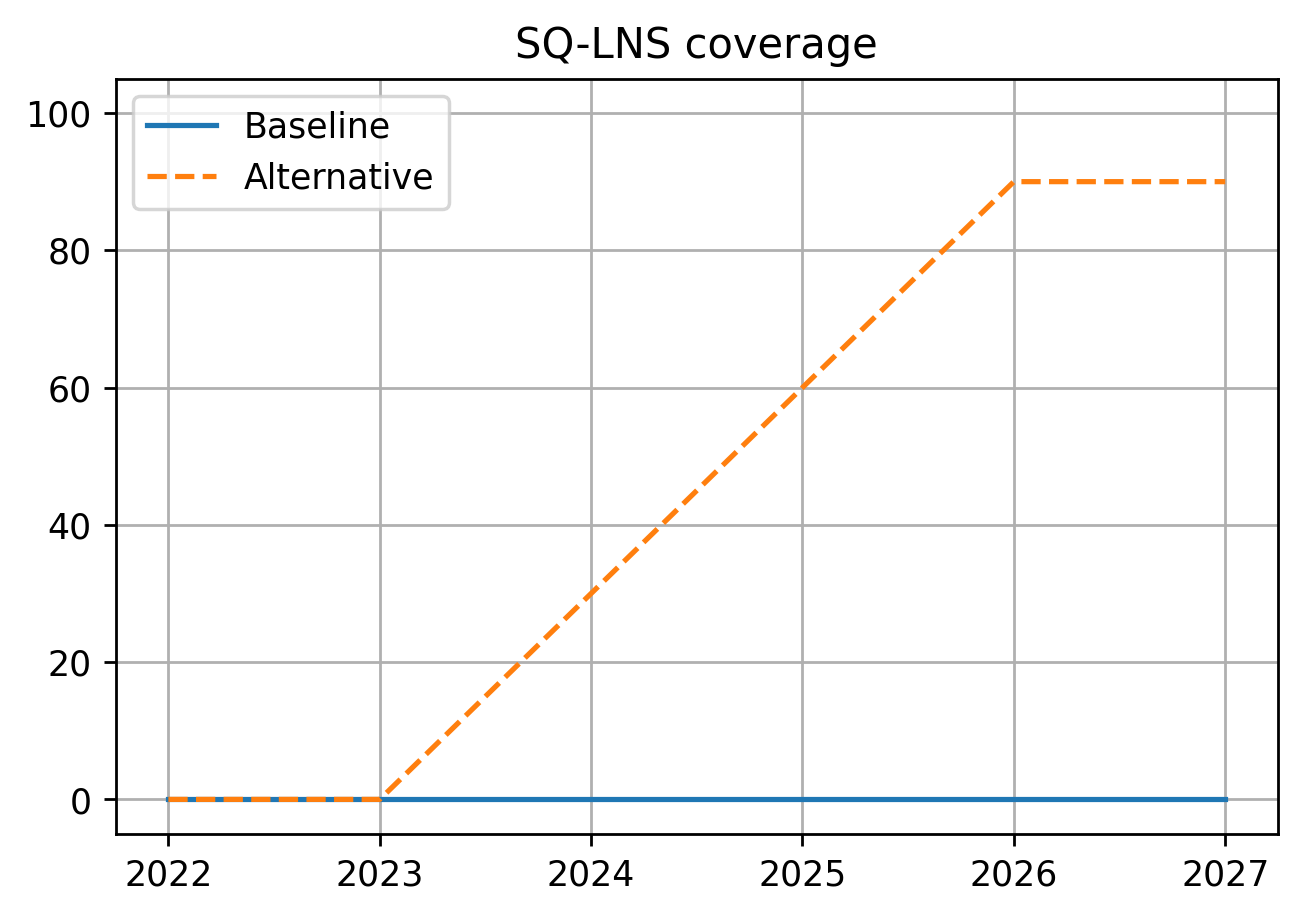

In [19]:
baseline_vals=[0]
baseline_ucls=[0]
baseline_lcls=[0]
targets=[90]
plt.figure(dpi=250)
for i in [0]:
    plt.plot(years,[baseline_vals[i]]*len(years))
    plt.fill_between(years, [baseline_lcls[i]]*len(years), [baseline_ucls[i]]*len(years),alpha=0.2)
    plt.plot([2022,2023,2026,2027],[baseline_vals[i],
                                                       baseline_vals[i],
                                                       targets[i],
                                                       targets[i]], linestyle='dashed')
    plt.fill_between([2022,2023,2026,2027],[baseline_lcls[i],
                                                       baseline_lcls[i],
                                                       targets[i],
                                                       targets[i]],
                                        [baseline_ucls[i],
                                                       baseline_ucls[i],
                                                       targets[i],
                                                       targets[i]],alpha=0.2)
plt.grid()
plt.ylim(-5,105)
plt.title('SQ-LNS coverage')
plt.legend(['Baseline','Alternative'])